# This notebook recreates plots in the results section of the paper

In [417]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

from stardate.lhf import convective_overturn_time

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Produce plots for the simulated data.

Load the simulated data set.

In [290]:
df = pd.read_csv("data/simulated_data.csv")
true_age_gyr = (10**df.age)*1e-9

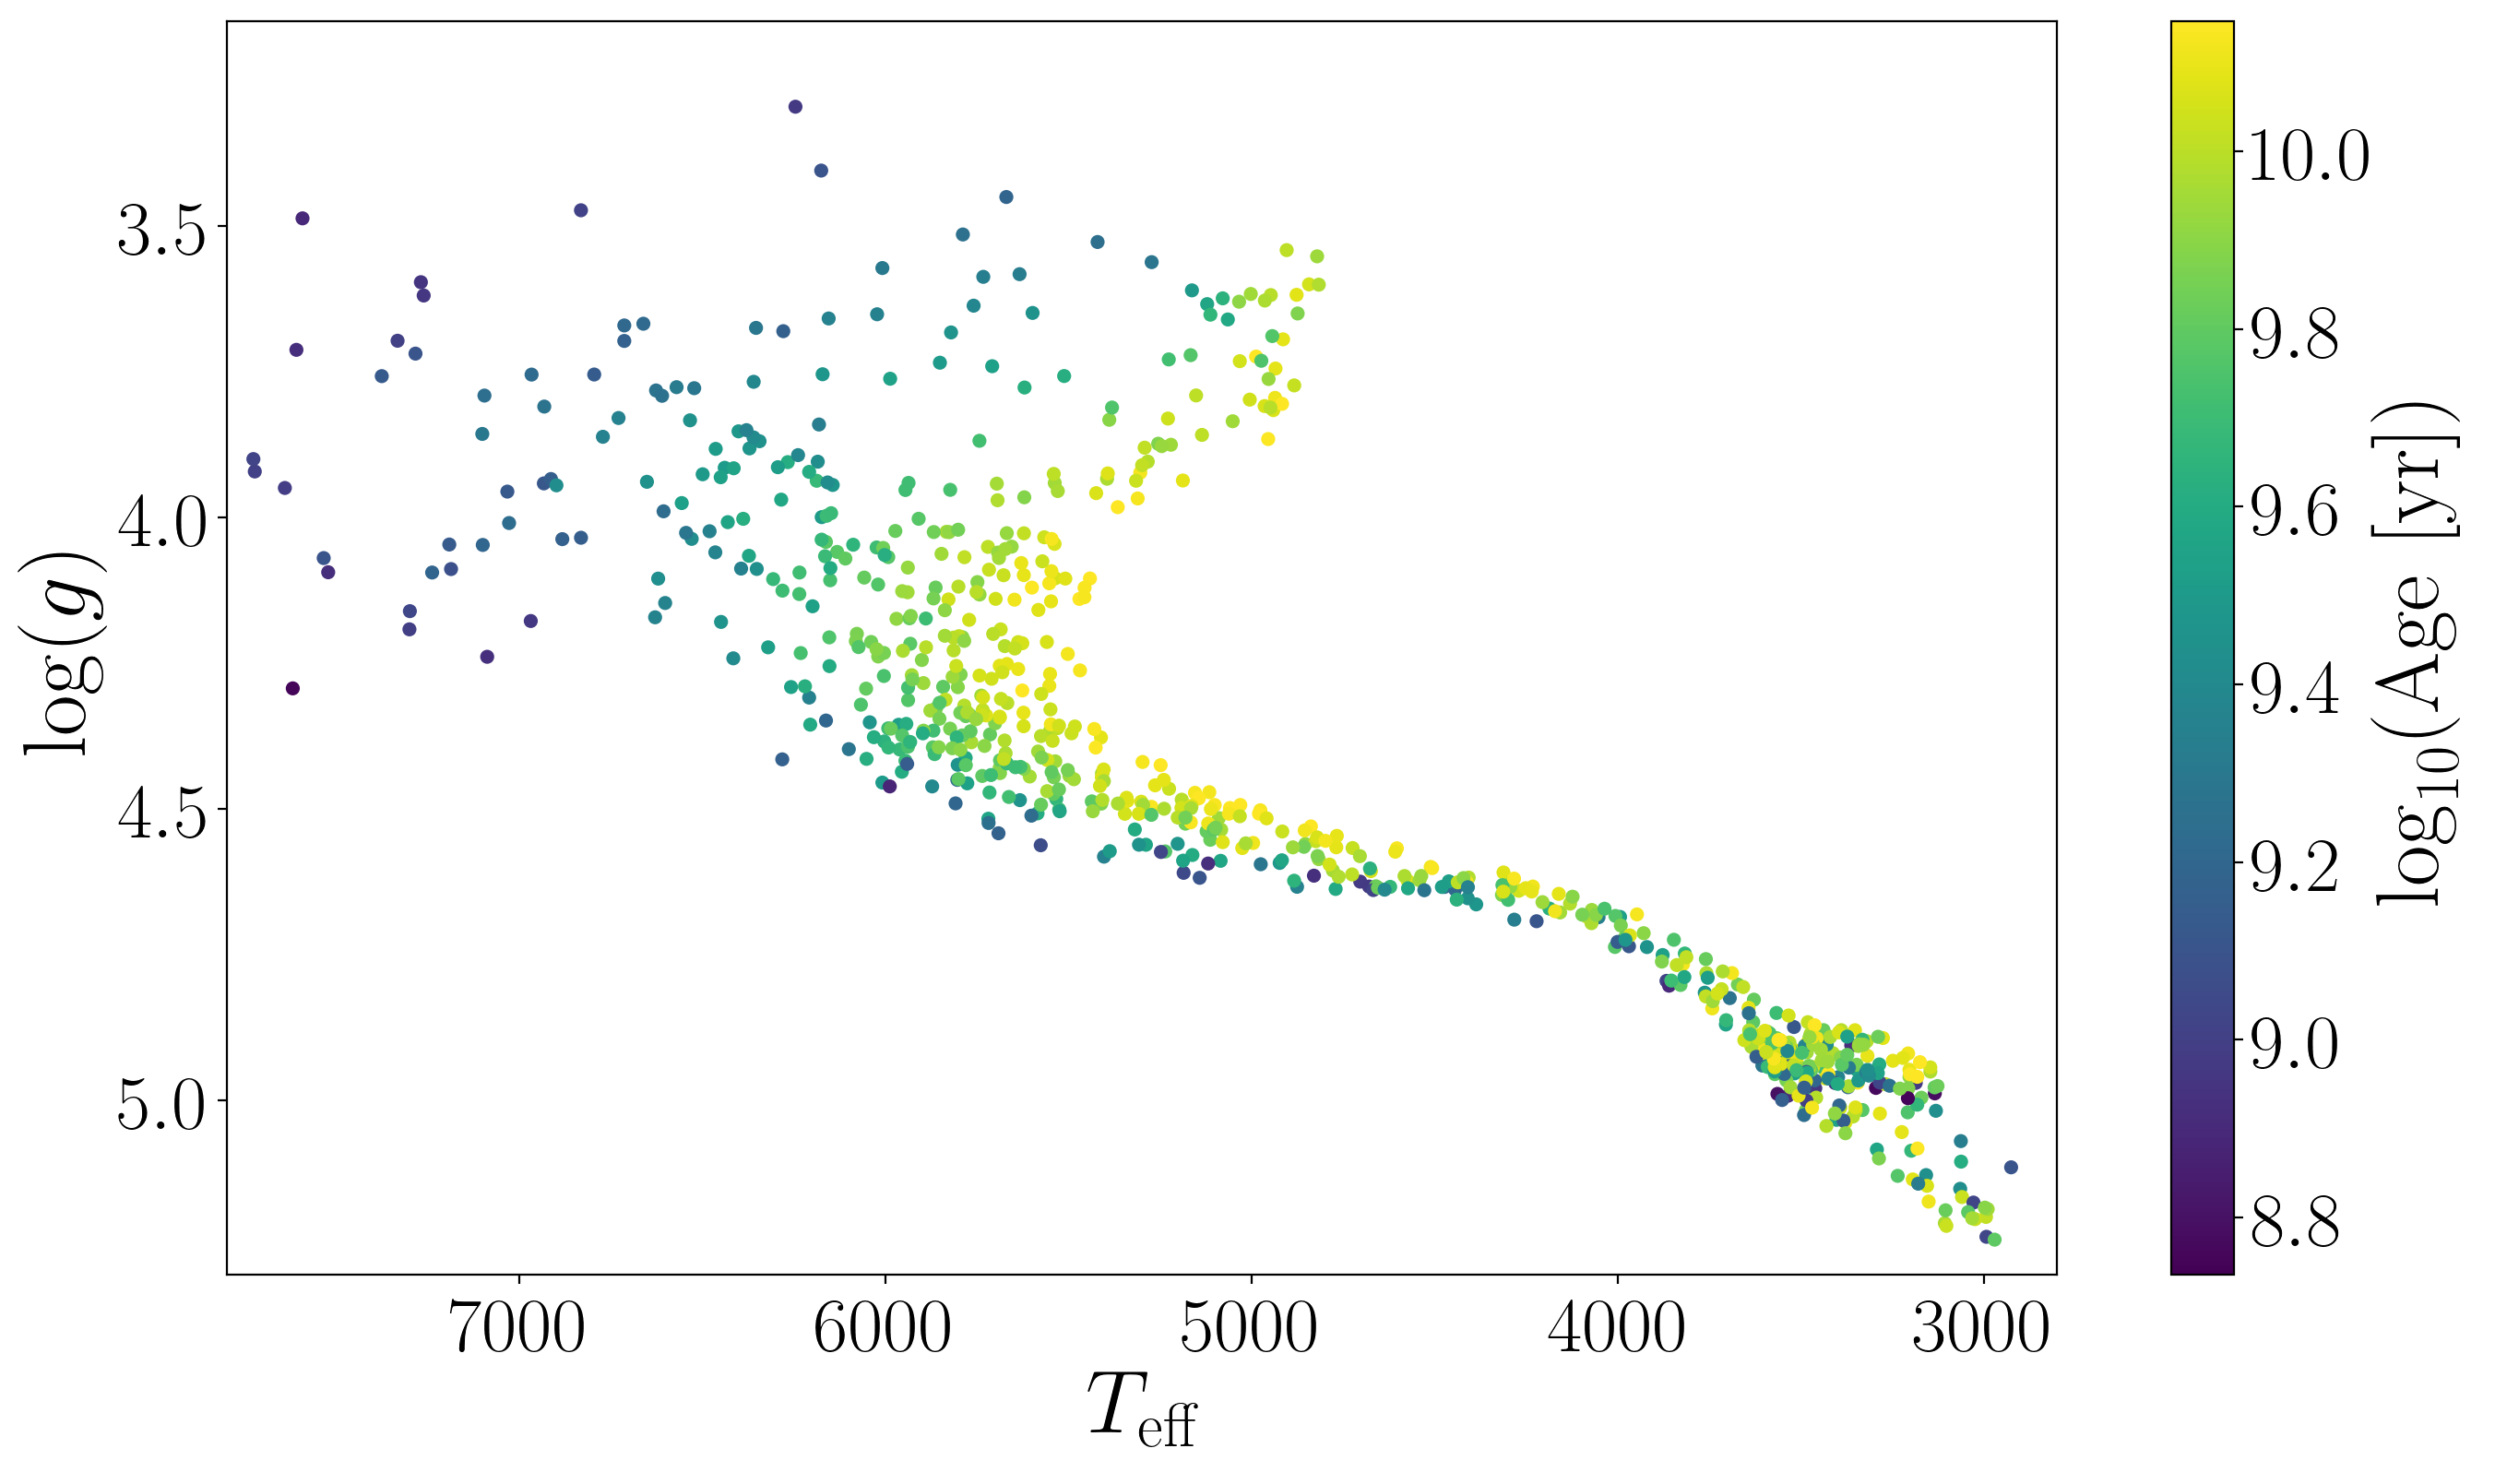

In [291]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.savefig("../simulated_CMD.pdf")

Plot a corner plot for the first star.

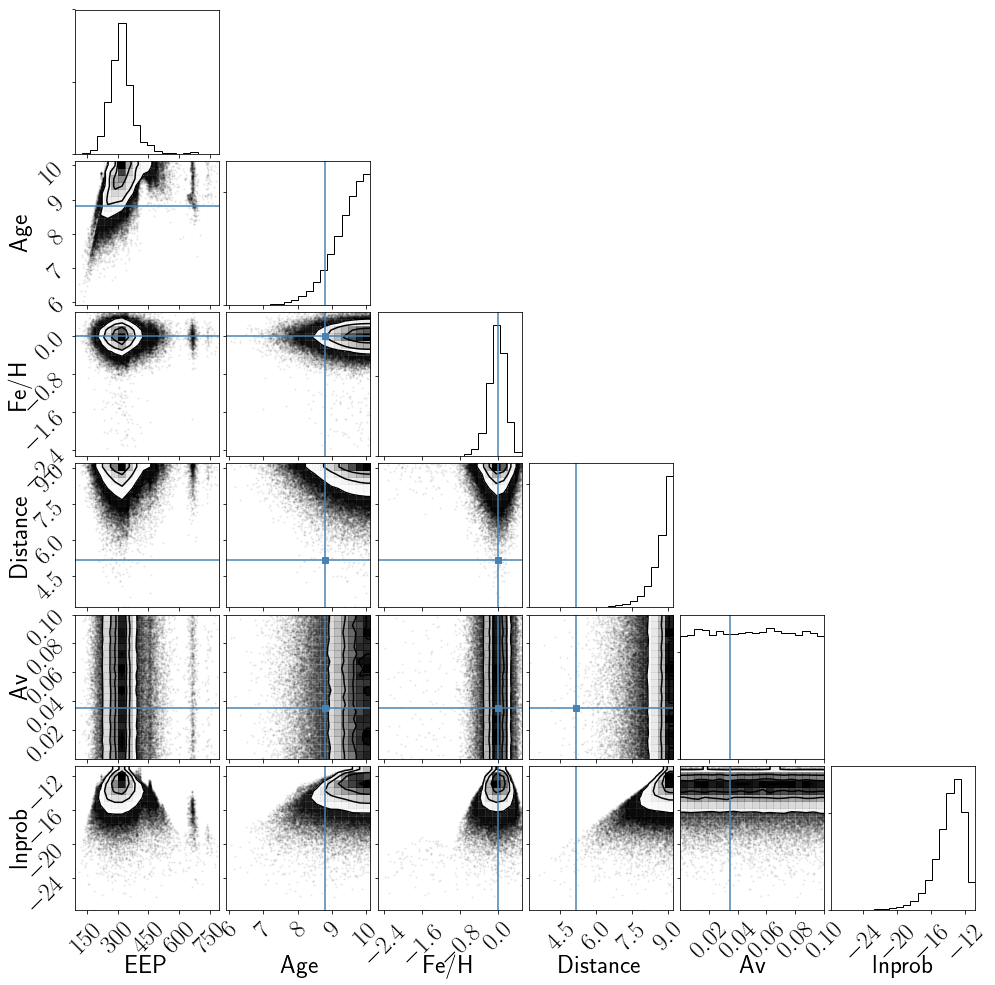

In [341]:
i = 0
fname = "simulation_results/{}_gyro.h5".format(str(i).zfill(4))

pr = pd.read_csv("data/praesepe.csv")
fname = "praesepe_results/{}_iso.h5".format(str(pr.EPIC.values[i]).zfill(9))
fname = "praesepe_results/211707676_praesepe_gyro.h5"

reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain()
lnprobs = reader.get_log_prob()
nsteps, nwalkers, ndim = np.shape(samples)
augmented = np.zeros((nsteps, nwalkers, ndim+1))
augmented[:, :, :-1] = samples
augmented[:, :, -1] = lnprobs
nsteps, nwalkers, ndim = np.shape(augmented)
    
burnin = 100
samps = np.reshape(augmented[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
tr = [df.eep.values[i], df.age.values[i], df.feh.values[i], np.log(1./(df.parallax[i]*1e-3)), df.Av.values[i], None]
tr = [None, np.log10(650*1e6), 0., np.log(177), .035, None]

labels = ["EEP", "Age", "Fe/H", "Distance", "Av", "lnprob"]
corner.corner(samps, truths=tr, labels=labels);

### And plot the trace.

[330.4679703080783, 9.989779673286511, 0.2094354524073248, 1.1549826956076465, 0.004040602965619203]


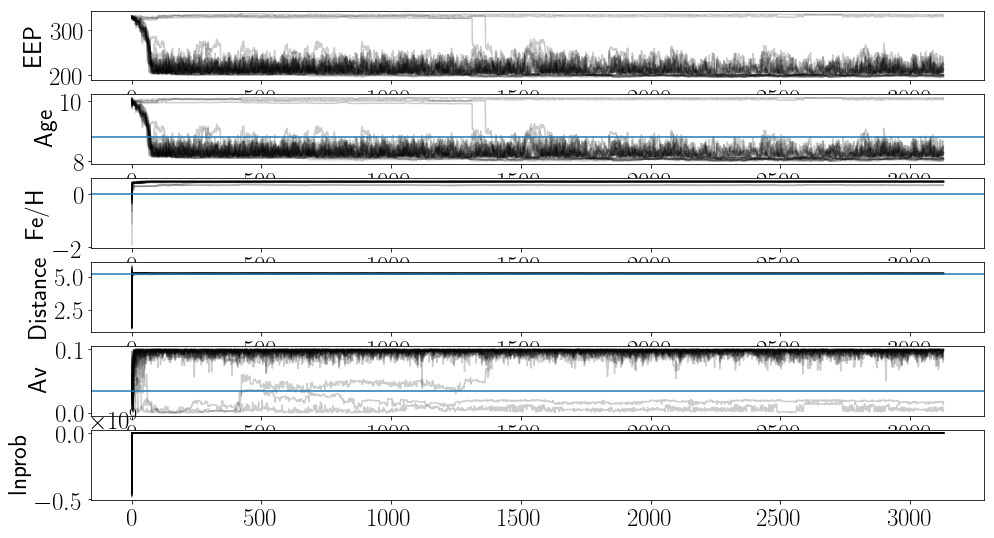

In [338]:
nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(5):
    plt.subplot(6, 1, j+1)
    inits.append(samples[0, 0, j])
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    plt.ylabel(labels[j])
    if tr[j] is not None:
        plt.axhline(tr[j])
plt.subplot(6, 1, 6)
plt.plot(lnprobs, "k", alpha=.5)
plt.ylabel(labels[5])
print(inits)

Now plot all the results.

In [387]:
def percentiles_from_samps(samps):
    med = np.median(samps)
    std = np.std(samps)
    upper = np.percentile(samps, 84)
    lower = np.percentile(samps, 16)
    errp = upper - med
    errm = med -lower
    return med, errp, errm, std


def read_files(name, ids, dirname=".", burnin=100):
    meds, age_samps, errp, errm, std, inds = [], [], [], [], [], []
    
    for i, ID in enumerate(ids):
        try:
            fname = "{0}/{1}_{2}.h5".format(dirname, str(int(ID)).zfill(4), name)
            reader = emcee.backends.HDFBackend(fname)
            samples = reader.get_chain()
            
            if np.shape(samples)[0] > 10:
                nsteps, nwalkers, ndim = np.shape(samples)
                samps = np.reshape(samples, (nsteps*nwalkers, ndim))
            
                a, ap, am, _std = percentiles_from_samps((10**samps[burnin:, 1])*1e-9)
                age_samps.append((10**samps[burnin:, 1])*1e-9)
                meds.append(a)
                errp.append(ap)
                errm.append(am)
                std.append(_std)
                inds.append(i)
                    
        except:
            pass
    
    return age_samps, np.array(meds), np.array(errp), np.array(errm), np.array(std), np.array(inds)

age_samps, meds, errp, errm, std, inds = read_files("stardate", np.arange(1000), dirname="simulation_results")
print(len(inds))

0


Select stars of different types.

In [295]:
def selection(df, inds):

    hot_cut, cool_cut, giant_cut, ro_cut = .45, 1.35, 440, 1.8
    Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
    evolved = (df.eep.values[inds] > giant_cut) #* (df.BV.values[inds] > hot_cut)
    hot = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] < giant_cut)
    hot_evolved = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] > giant_cut)
    cool = (df.BV.values[inds] > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
    fgk = (df.eep.values[inds] < giant_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
            * (Ro < ro_cut)
    rossbied = (Ro > ro_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
        * (df.eep.values[inds] < giant_cut)
    return fgk, hot, cool, evolved, rossbied

fgk, hot, cool, evolved, rossbied = selection(df, inds)

Plot the empirical precision on the HR diagram (use log g to spread out the main sequence better).

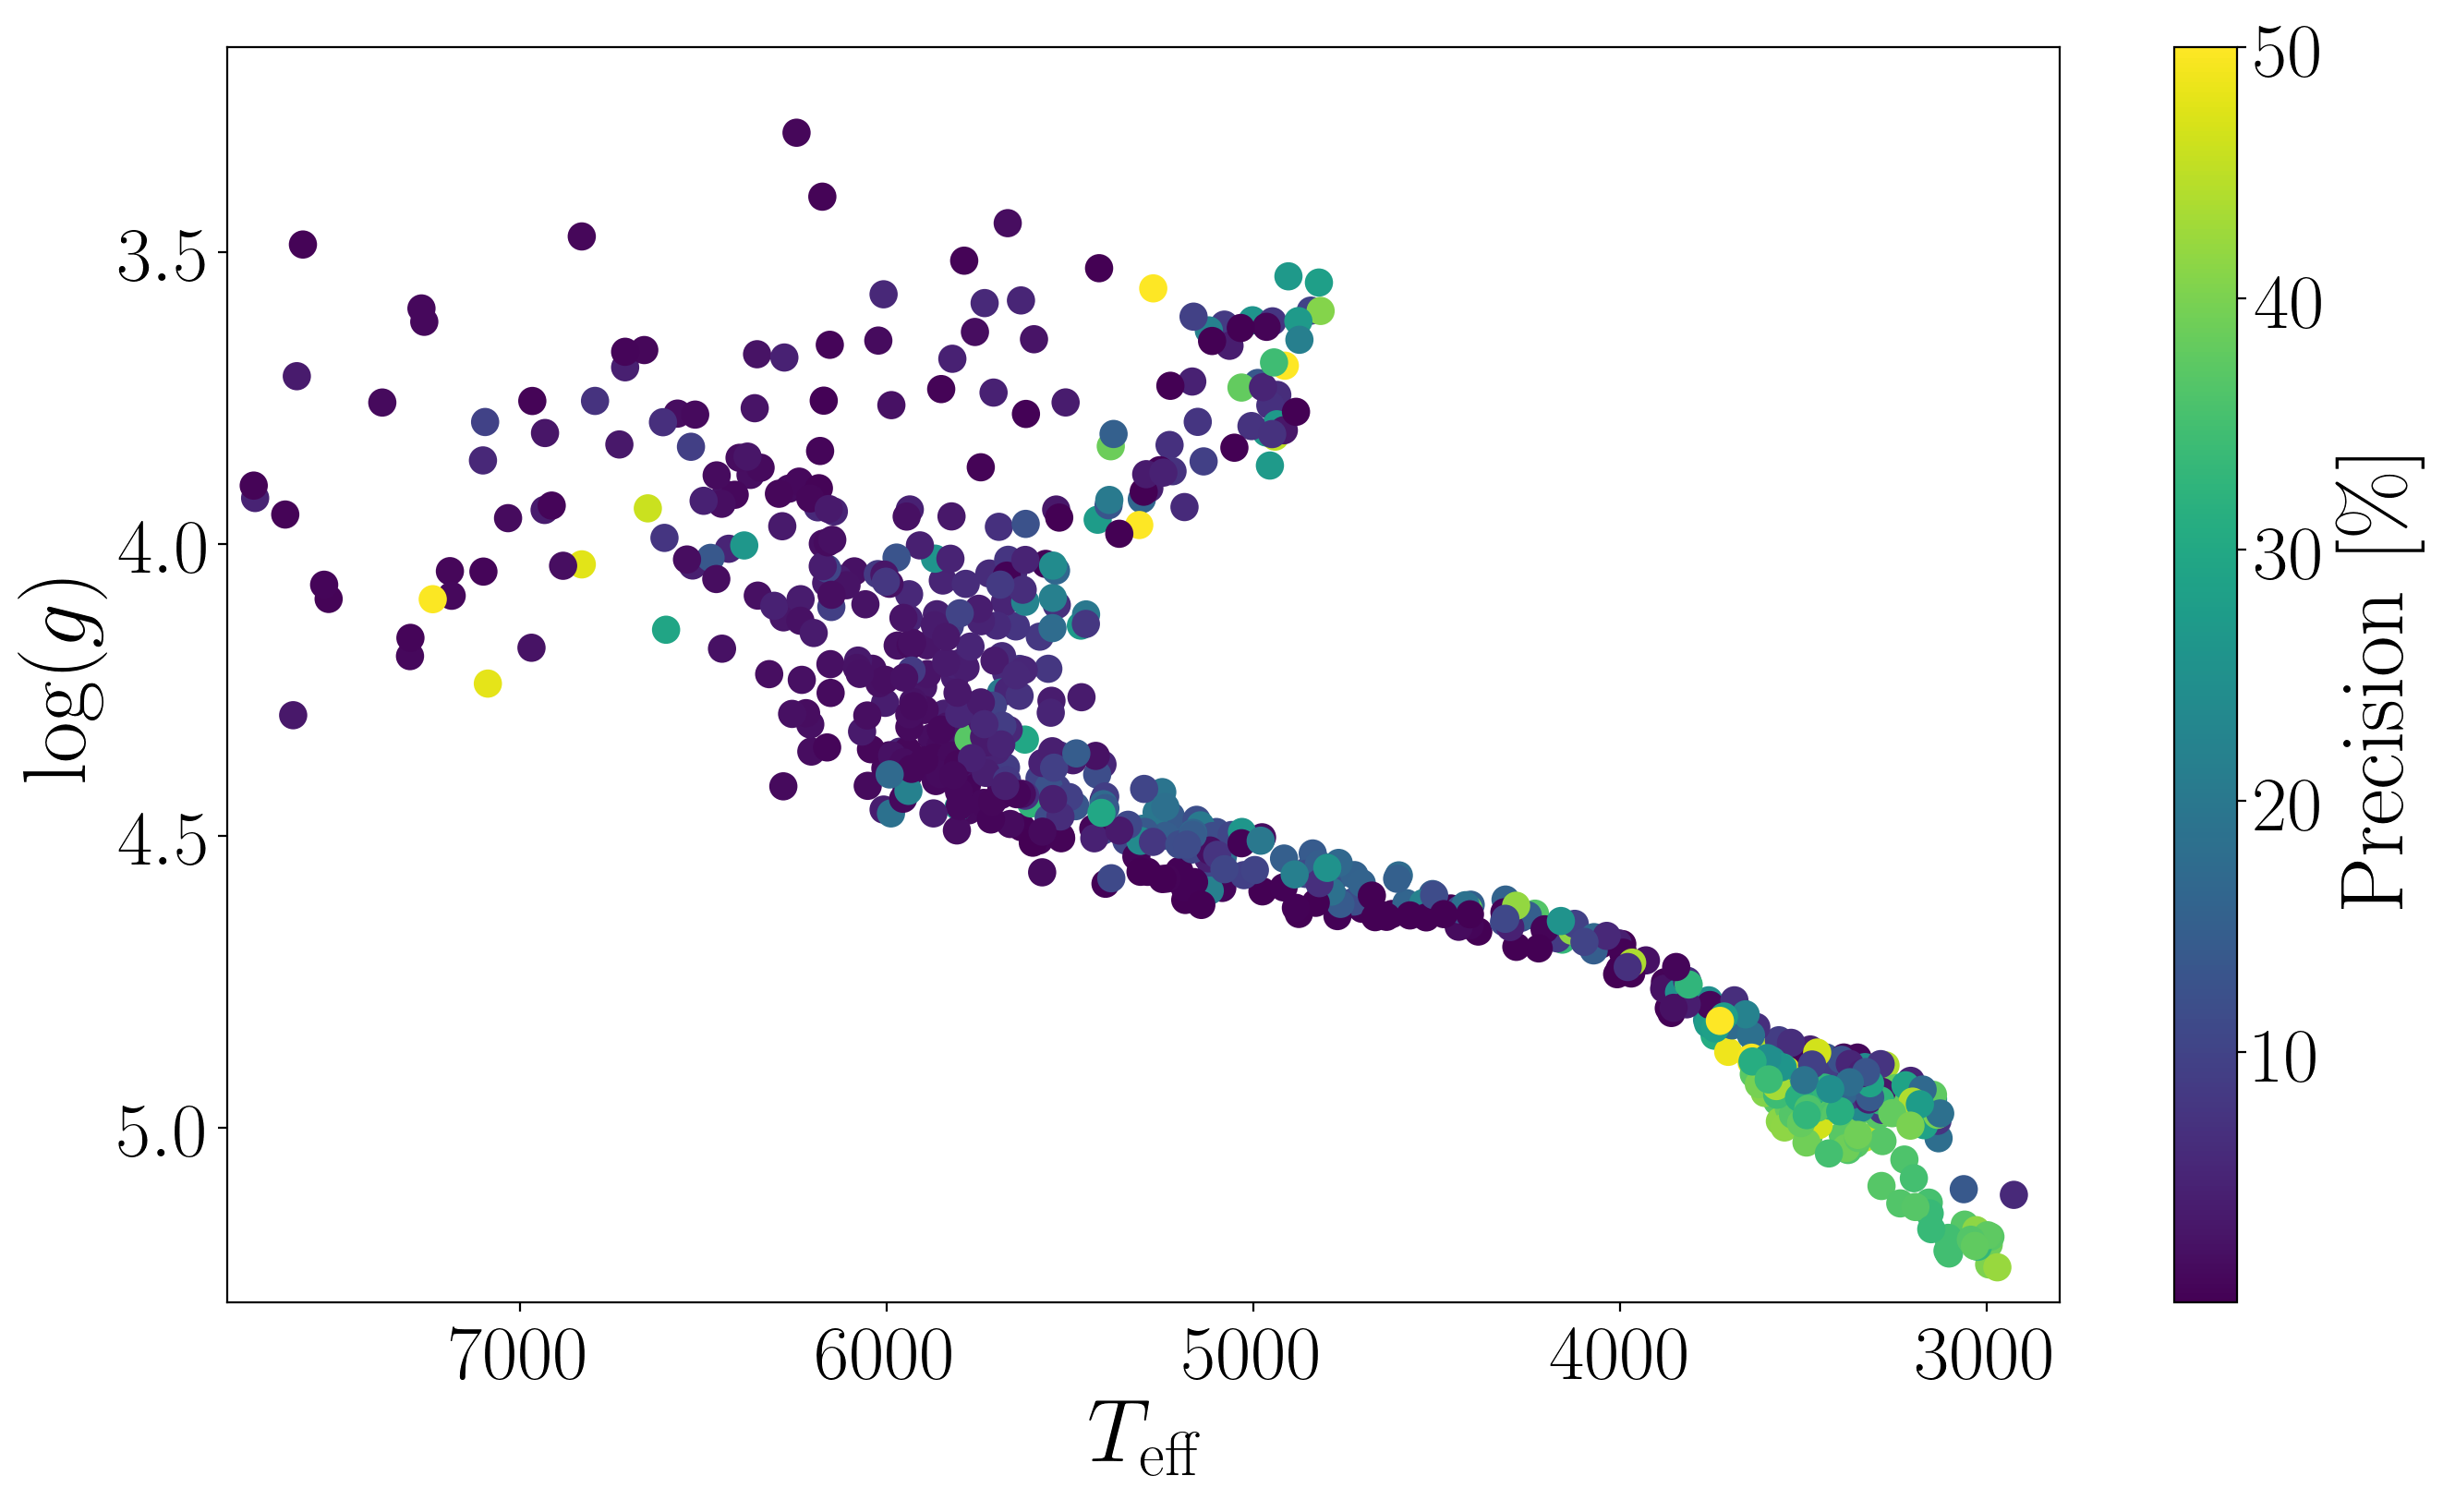

In [298]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds],
            c=(std/df.age.values[inds])*100, s=100, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.savefig("precision_plot")
plt.savefig("../precision_plot.pdf")

Error plot (accuracy)

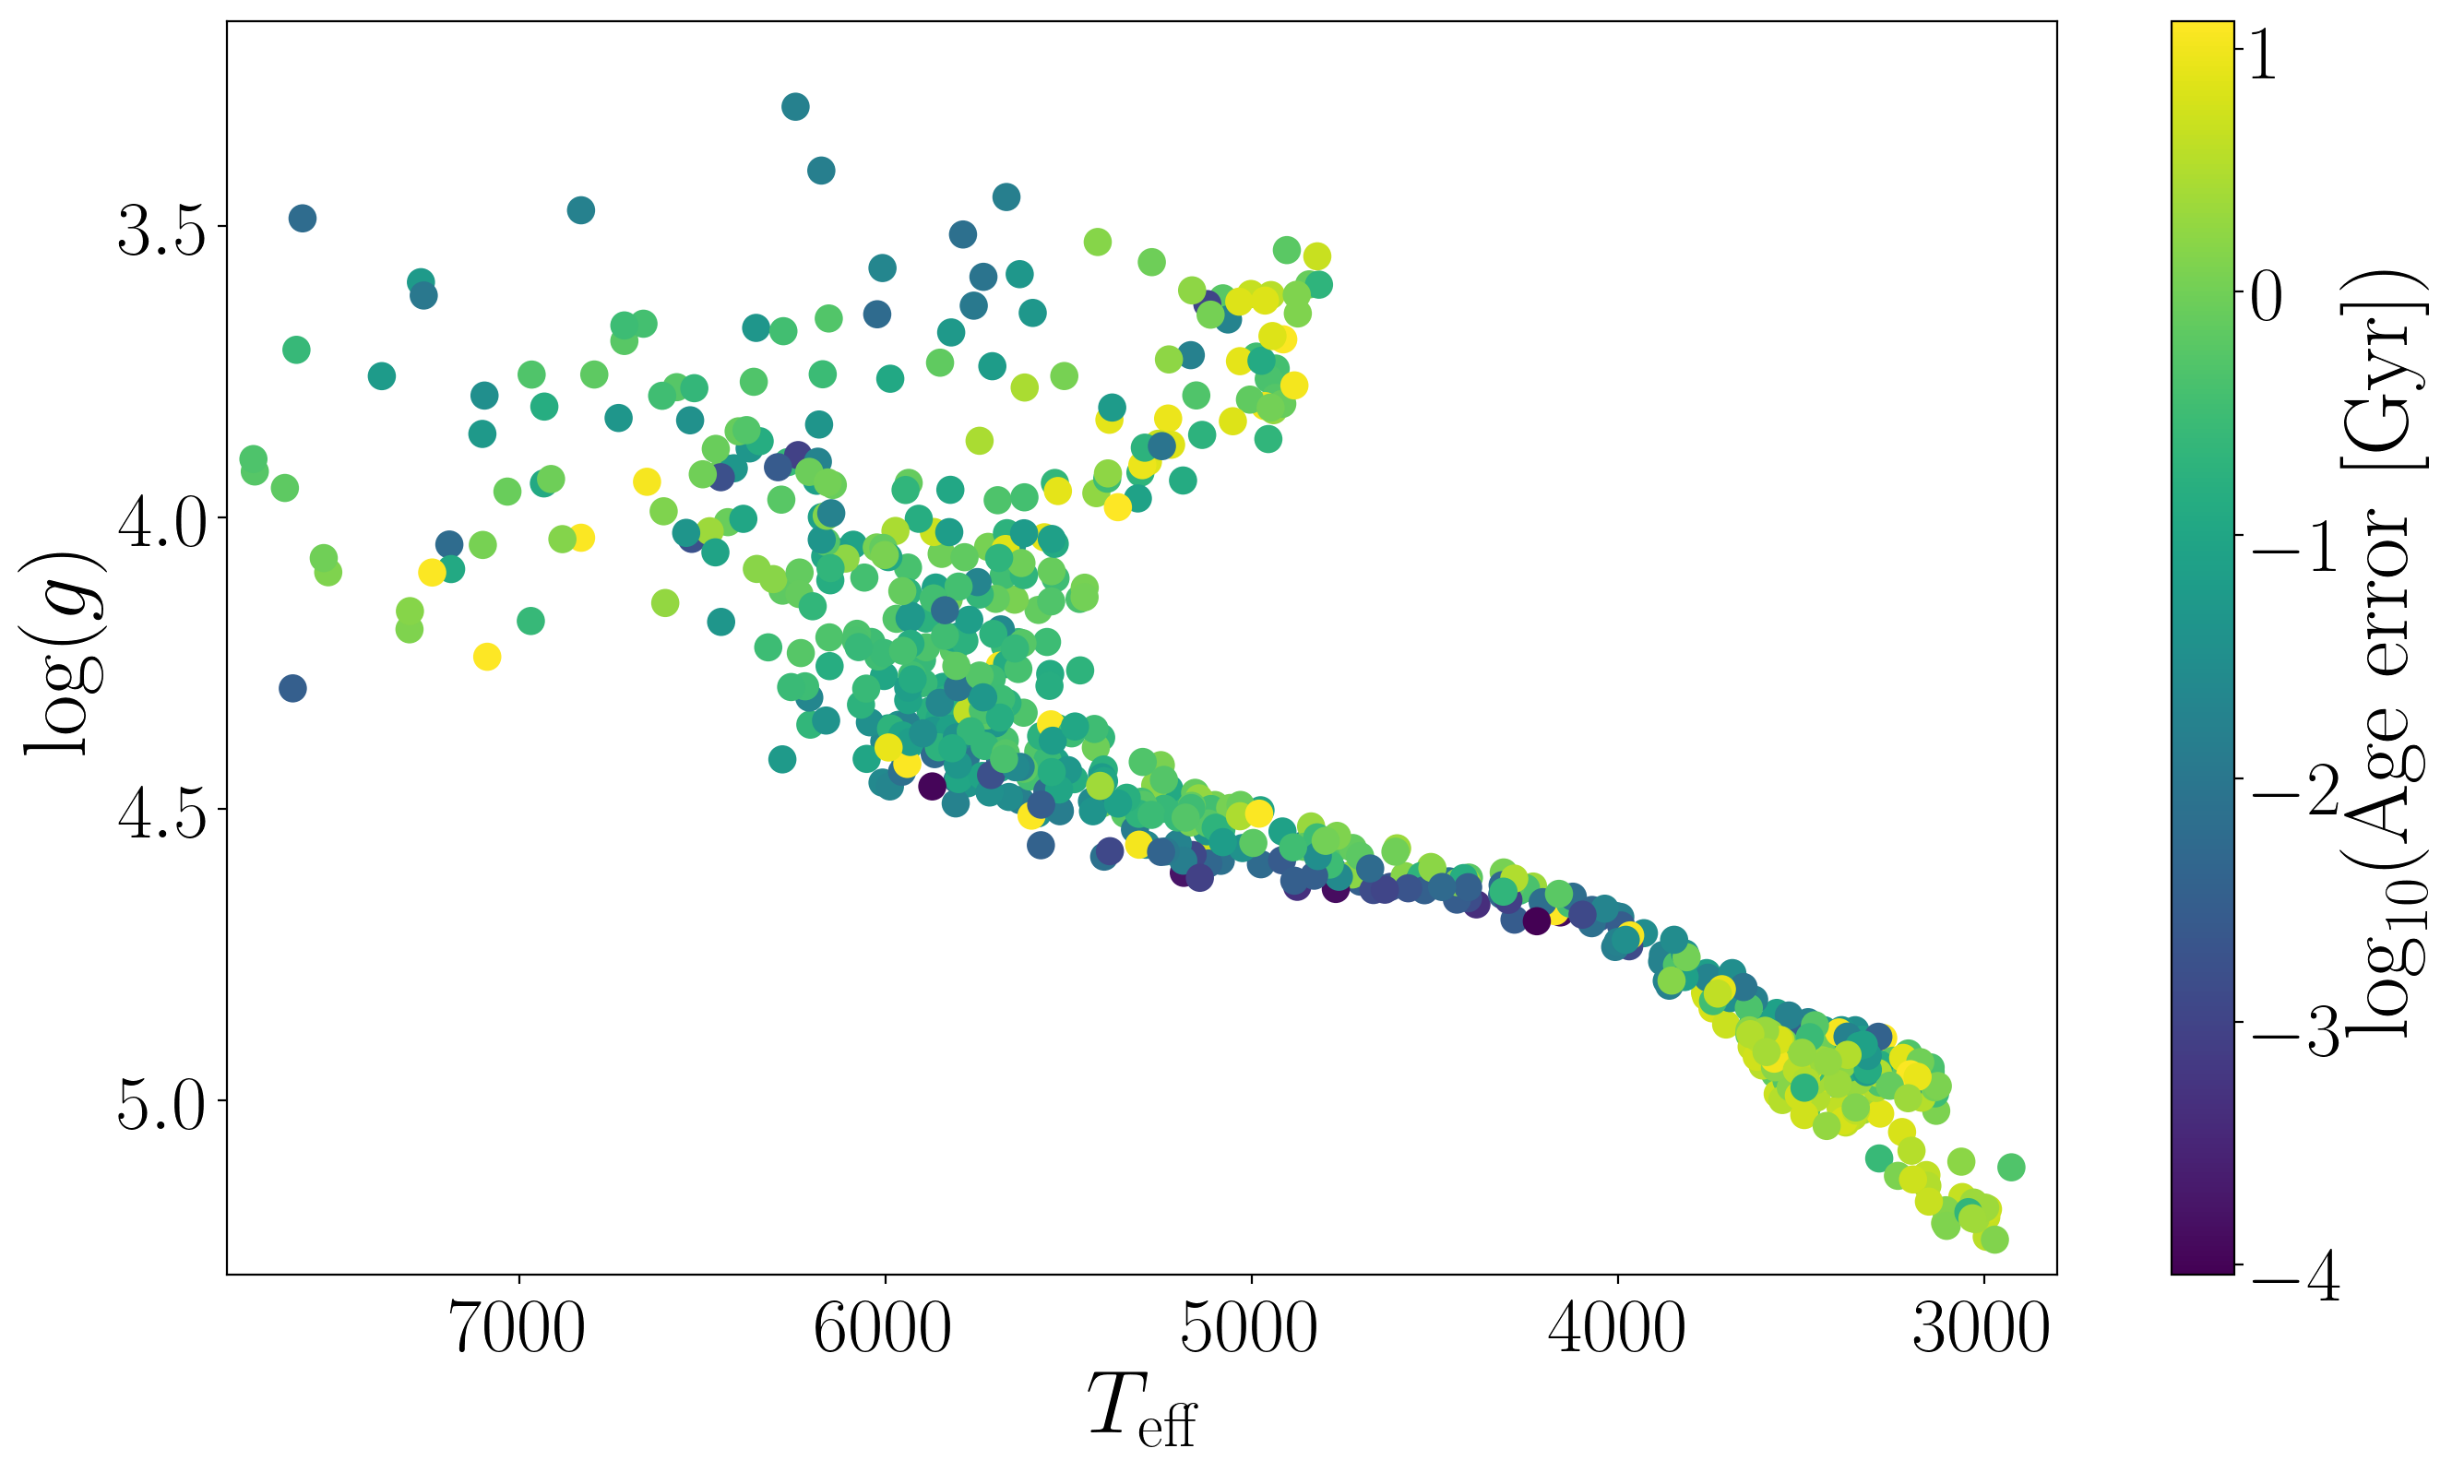

In [299]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds],
            c=np.log10(abs(true_age_gyr[inds] - meds)), s=100)
plt.colorbar(label="$\mathrm{\log_{10}(Age~error~[Gyr])}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.savefig("error_plot")
plt.savefig("../error_plot.pdf")

Text(0, 0.5, '$\\log(g)$')

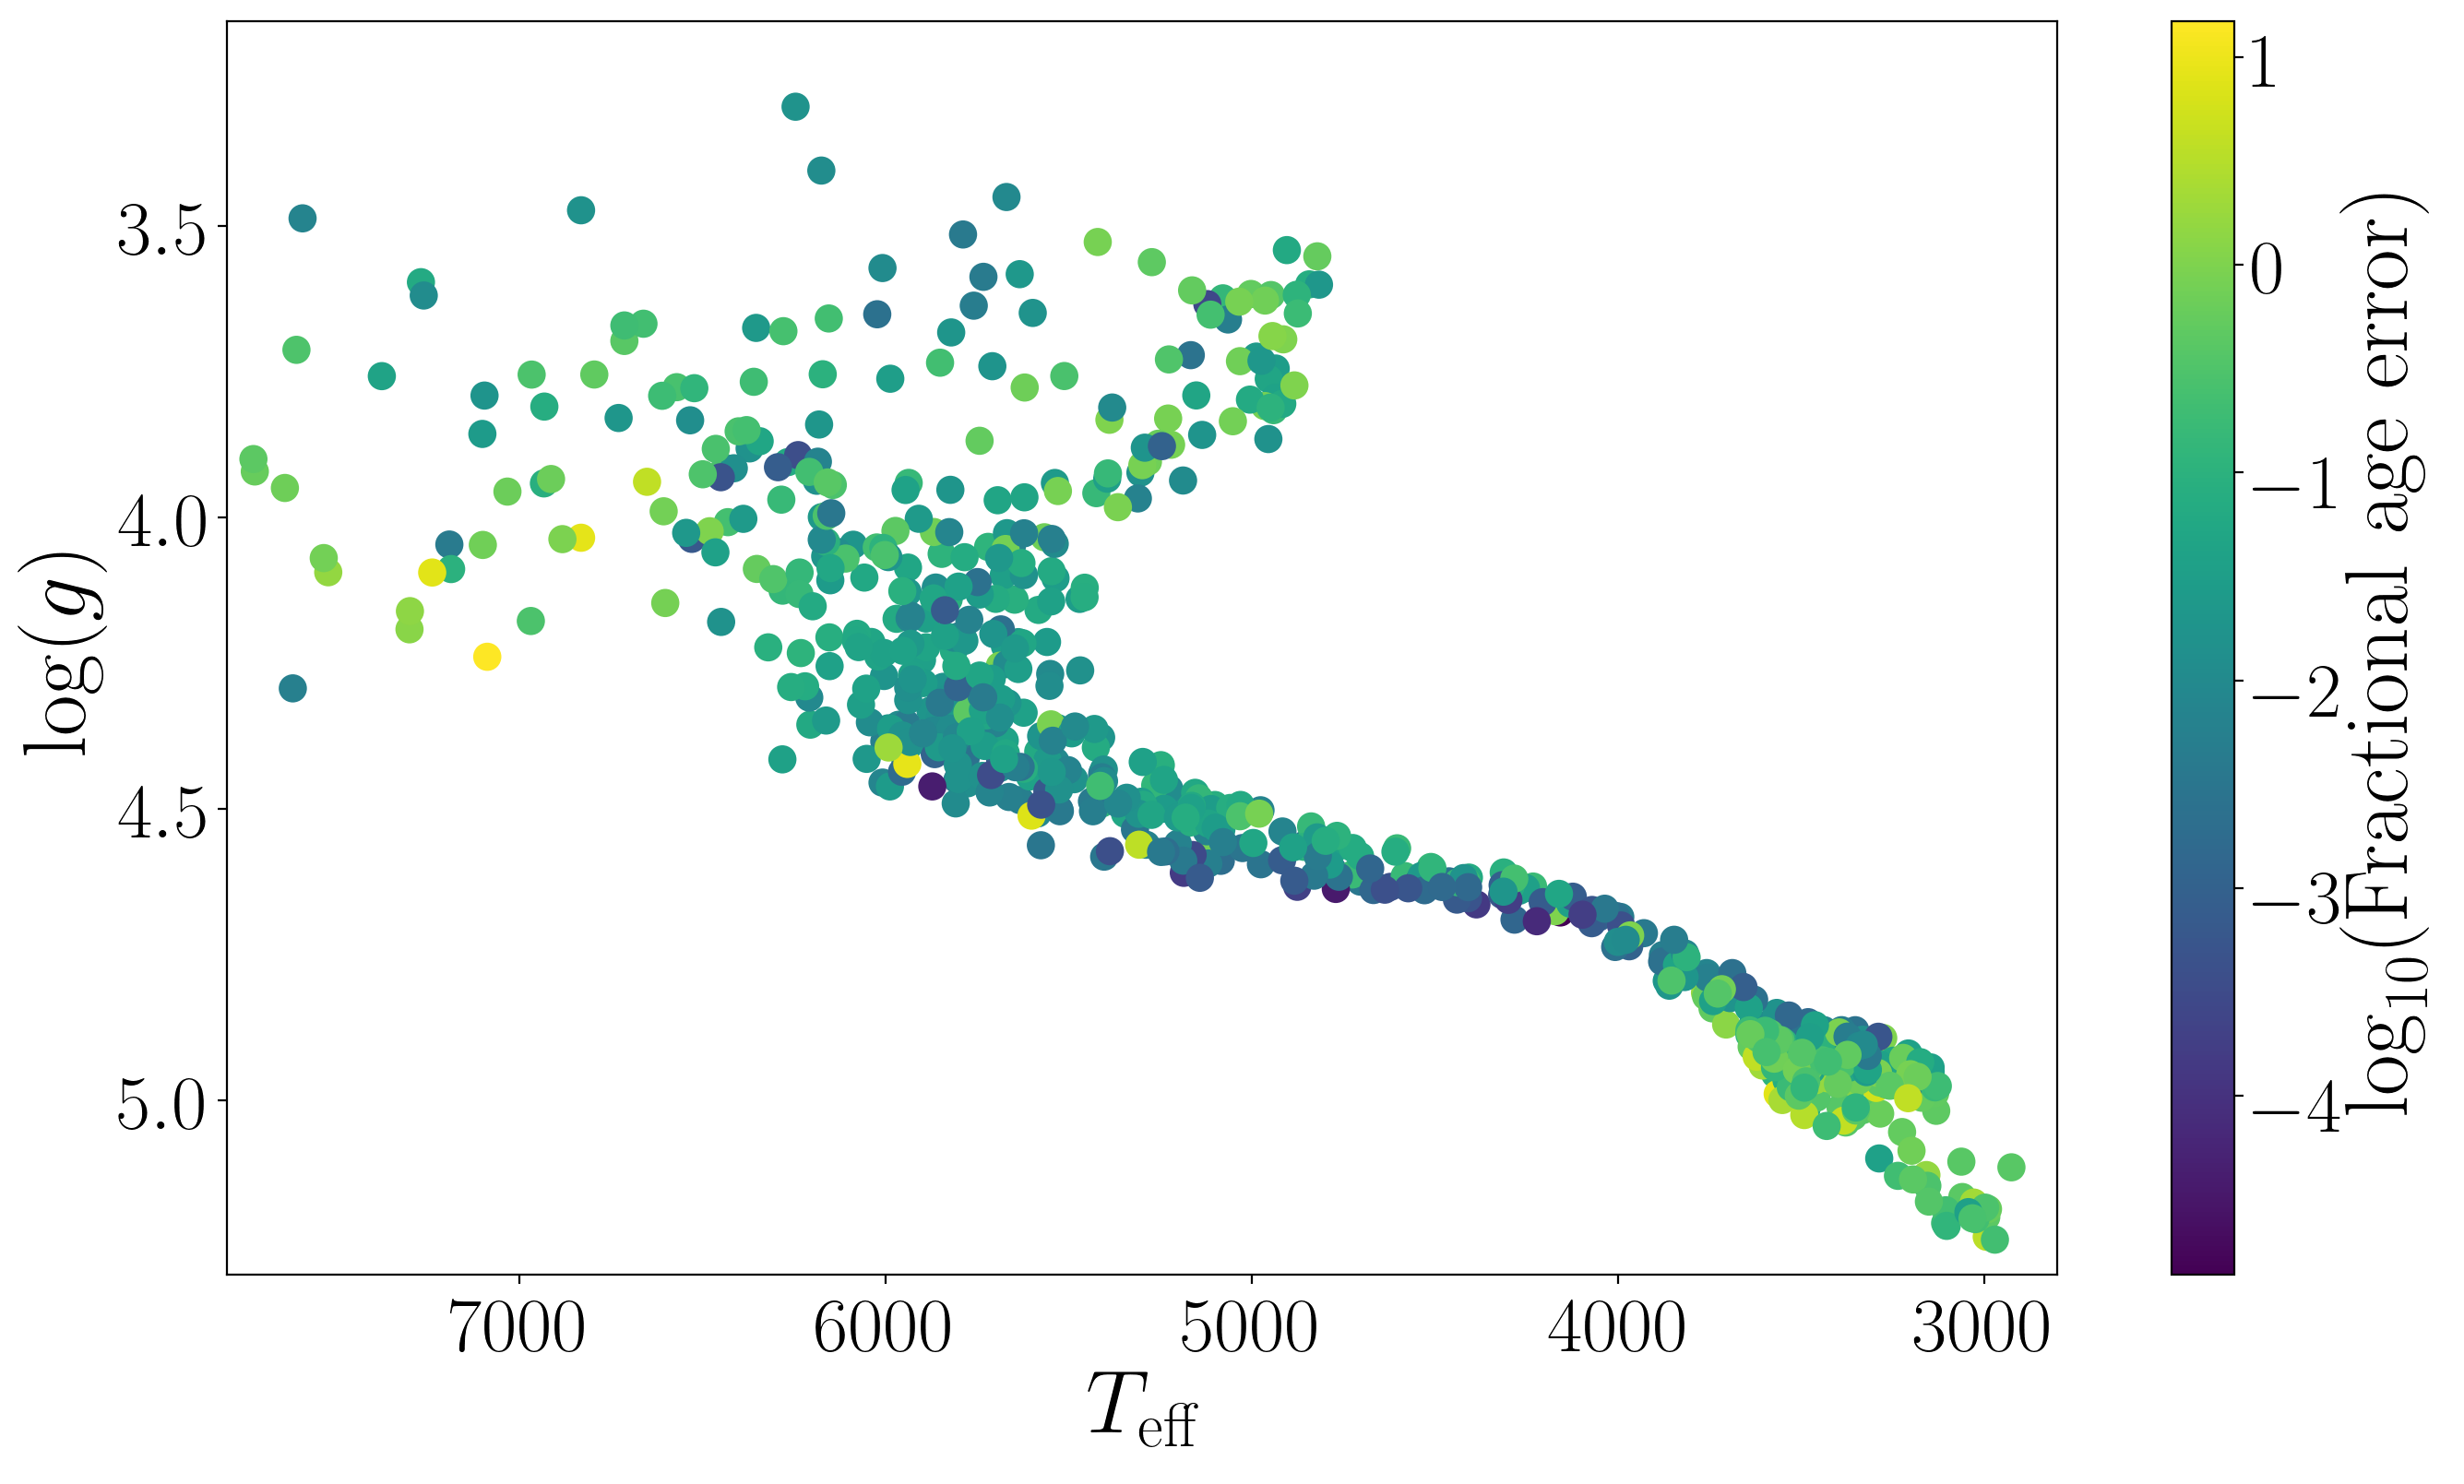

In [300]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds],
            c=np.log10(abs(true_age_gyr[inds] - meds)/true_age_gyr[inds]), s=100)
plt.colorbar(label="$\mathrm{\log_{10}(Fractional~age~error)}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now just the isochrone model.

In [301]:
iage_samps, imeds, ierrp, ierrm, istd, iinds = read_files("isochrones", np.arange(1000))

In [302]:
ifgk, ihot, icool, ievolved, irossbied = selection(df, iinds)

Precision plot

Text(0, 0.5, '$\\log(g)$')

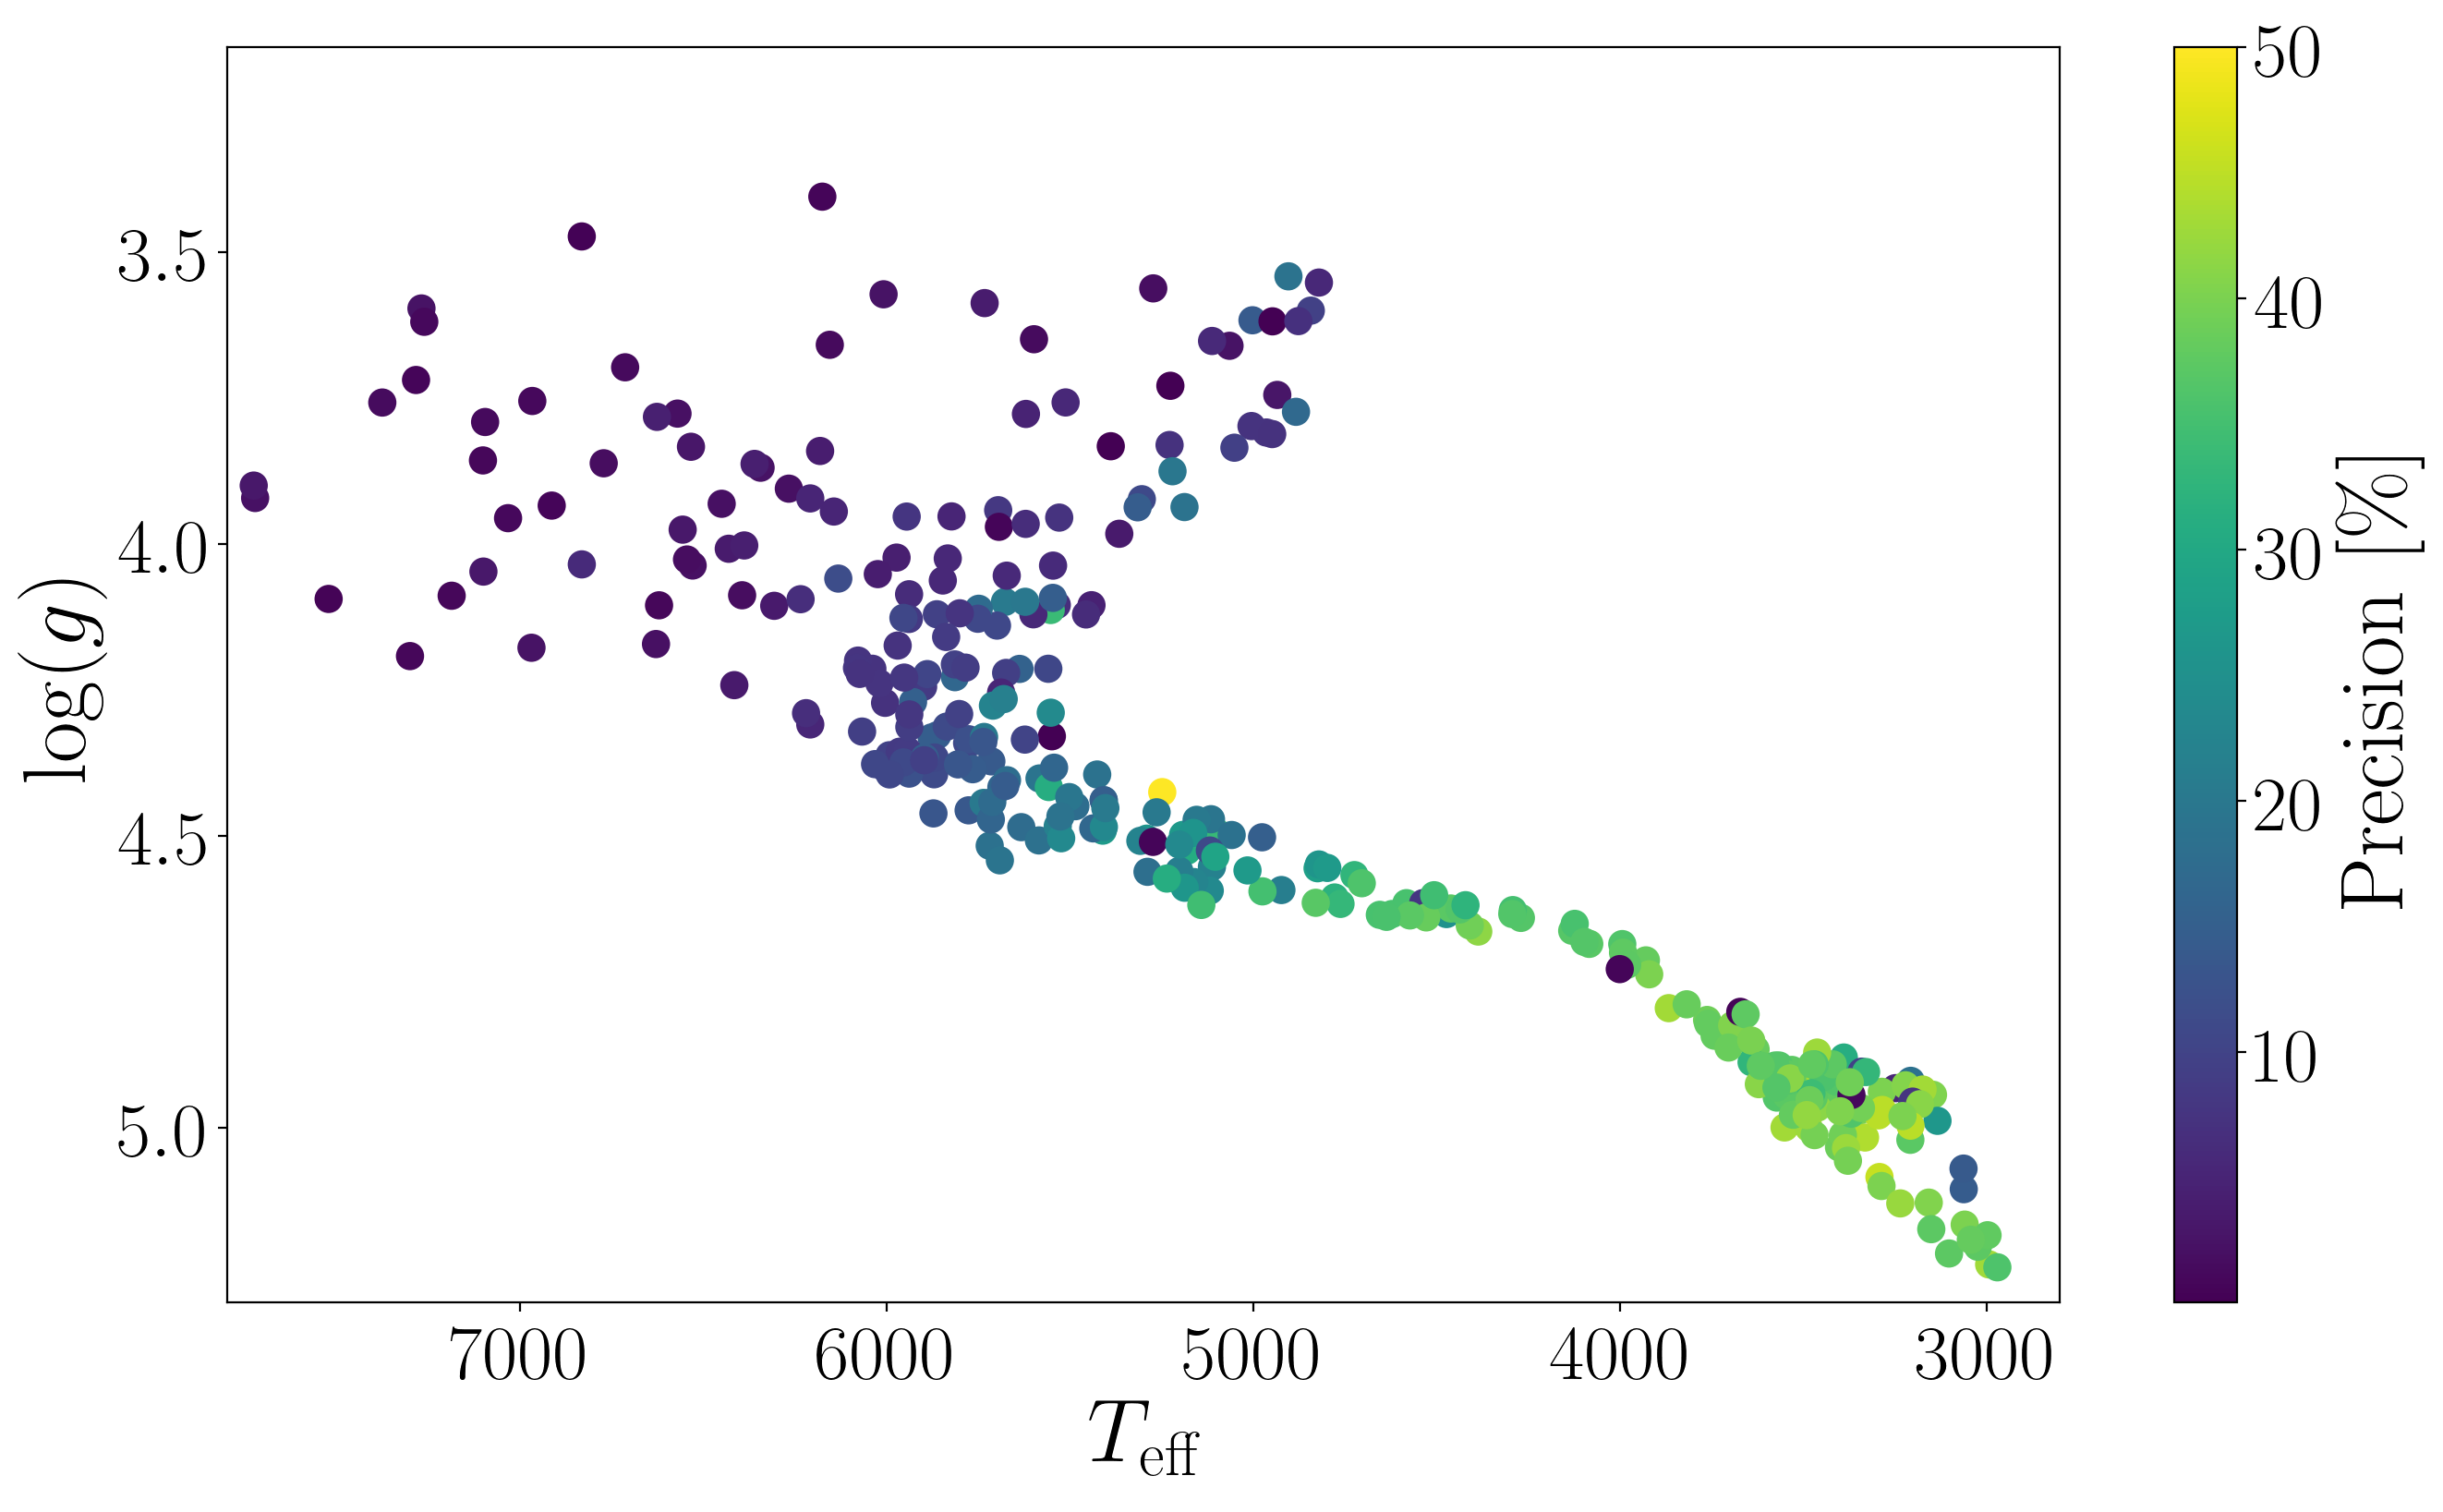

In [303]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[iinds], df.logg.values[iinds],
            c=(istd/df.age.values[iinds])*100, s=100, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Error plot.

Text(0, 0.5, '$\\log(g)$')

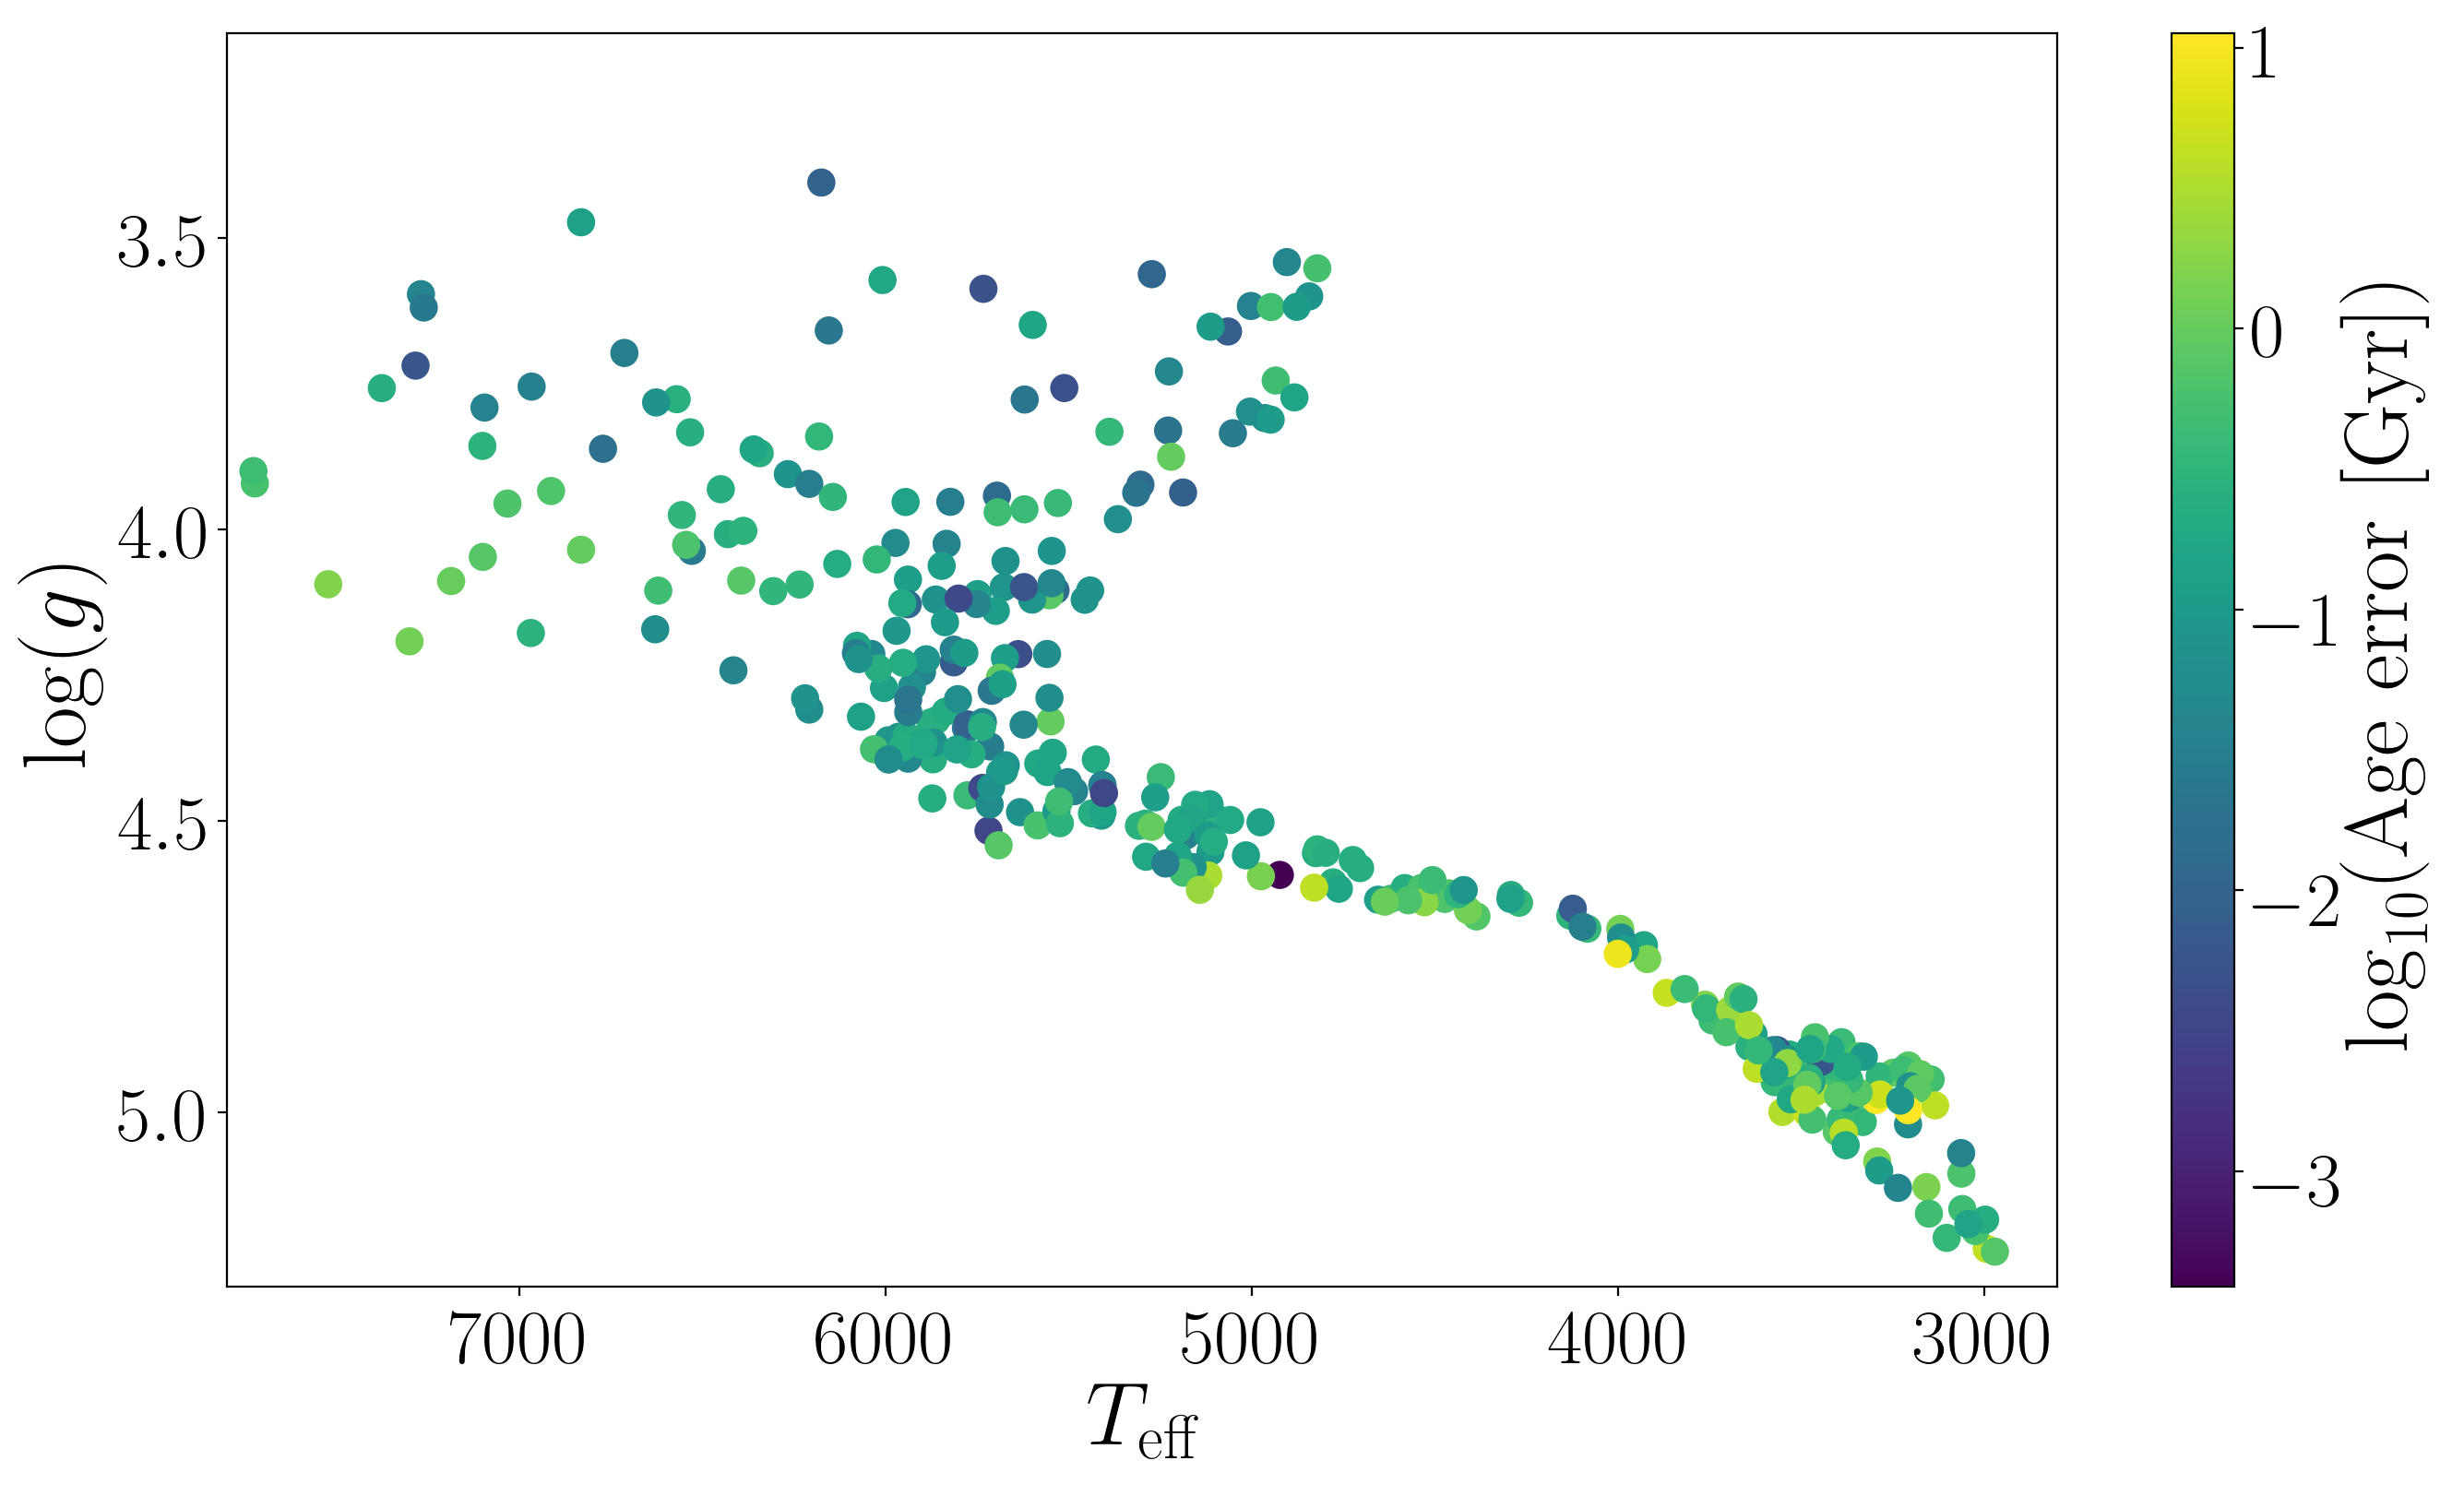

In [304]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[iinds], df.logg.values[iinds],
            c=np.log10(abs(true_age_gyr[iinds] - imeds)/true_age_gyr[iinds]), s=100)
plt.colorbar(label="$\mathrm{\log_{10}(Age~error~[Gyr])}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

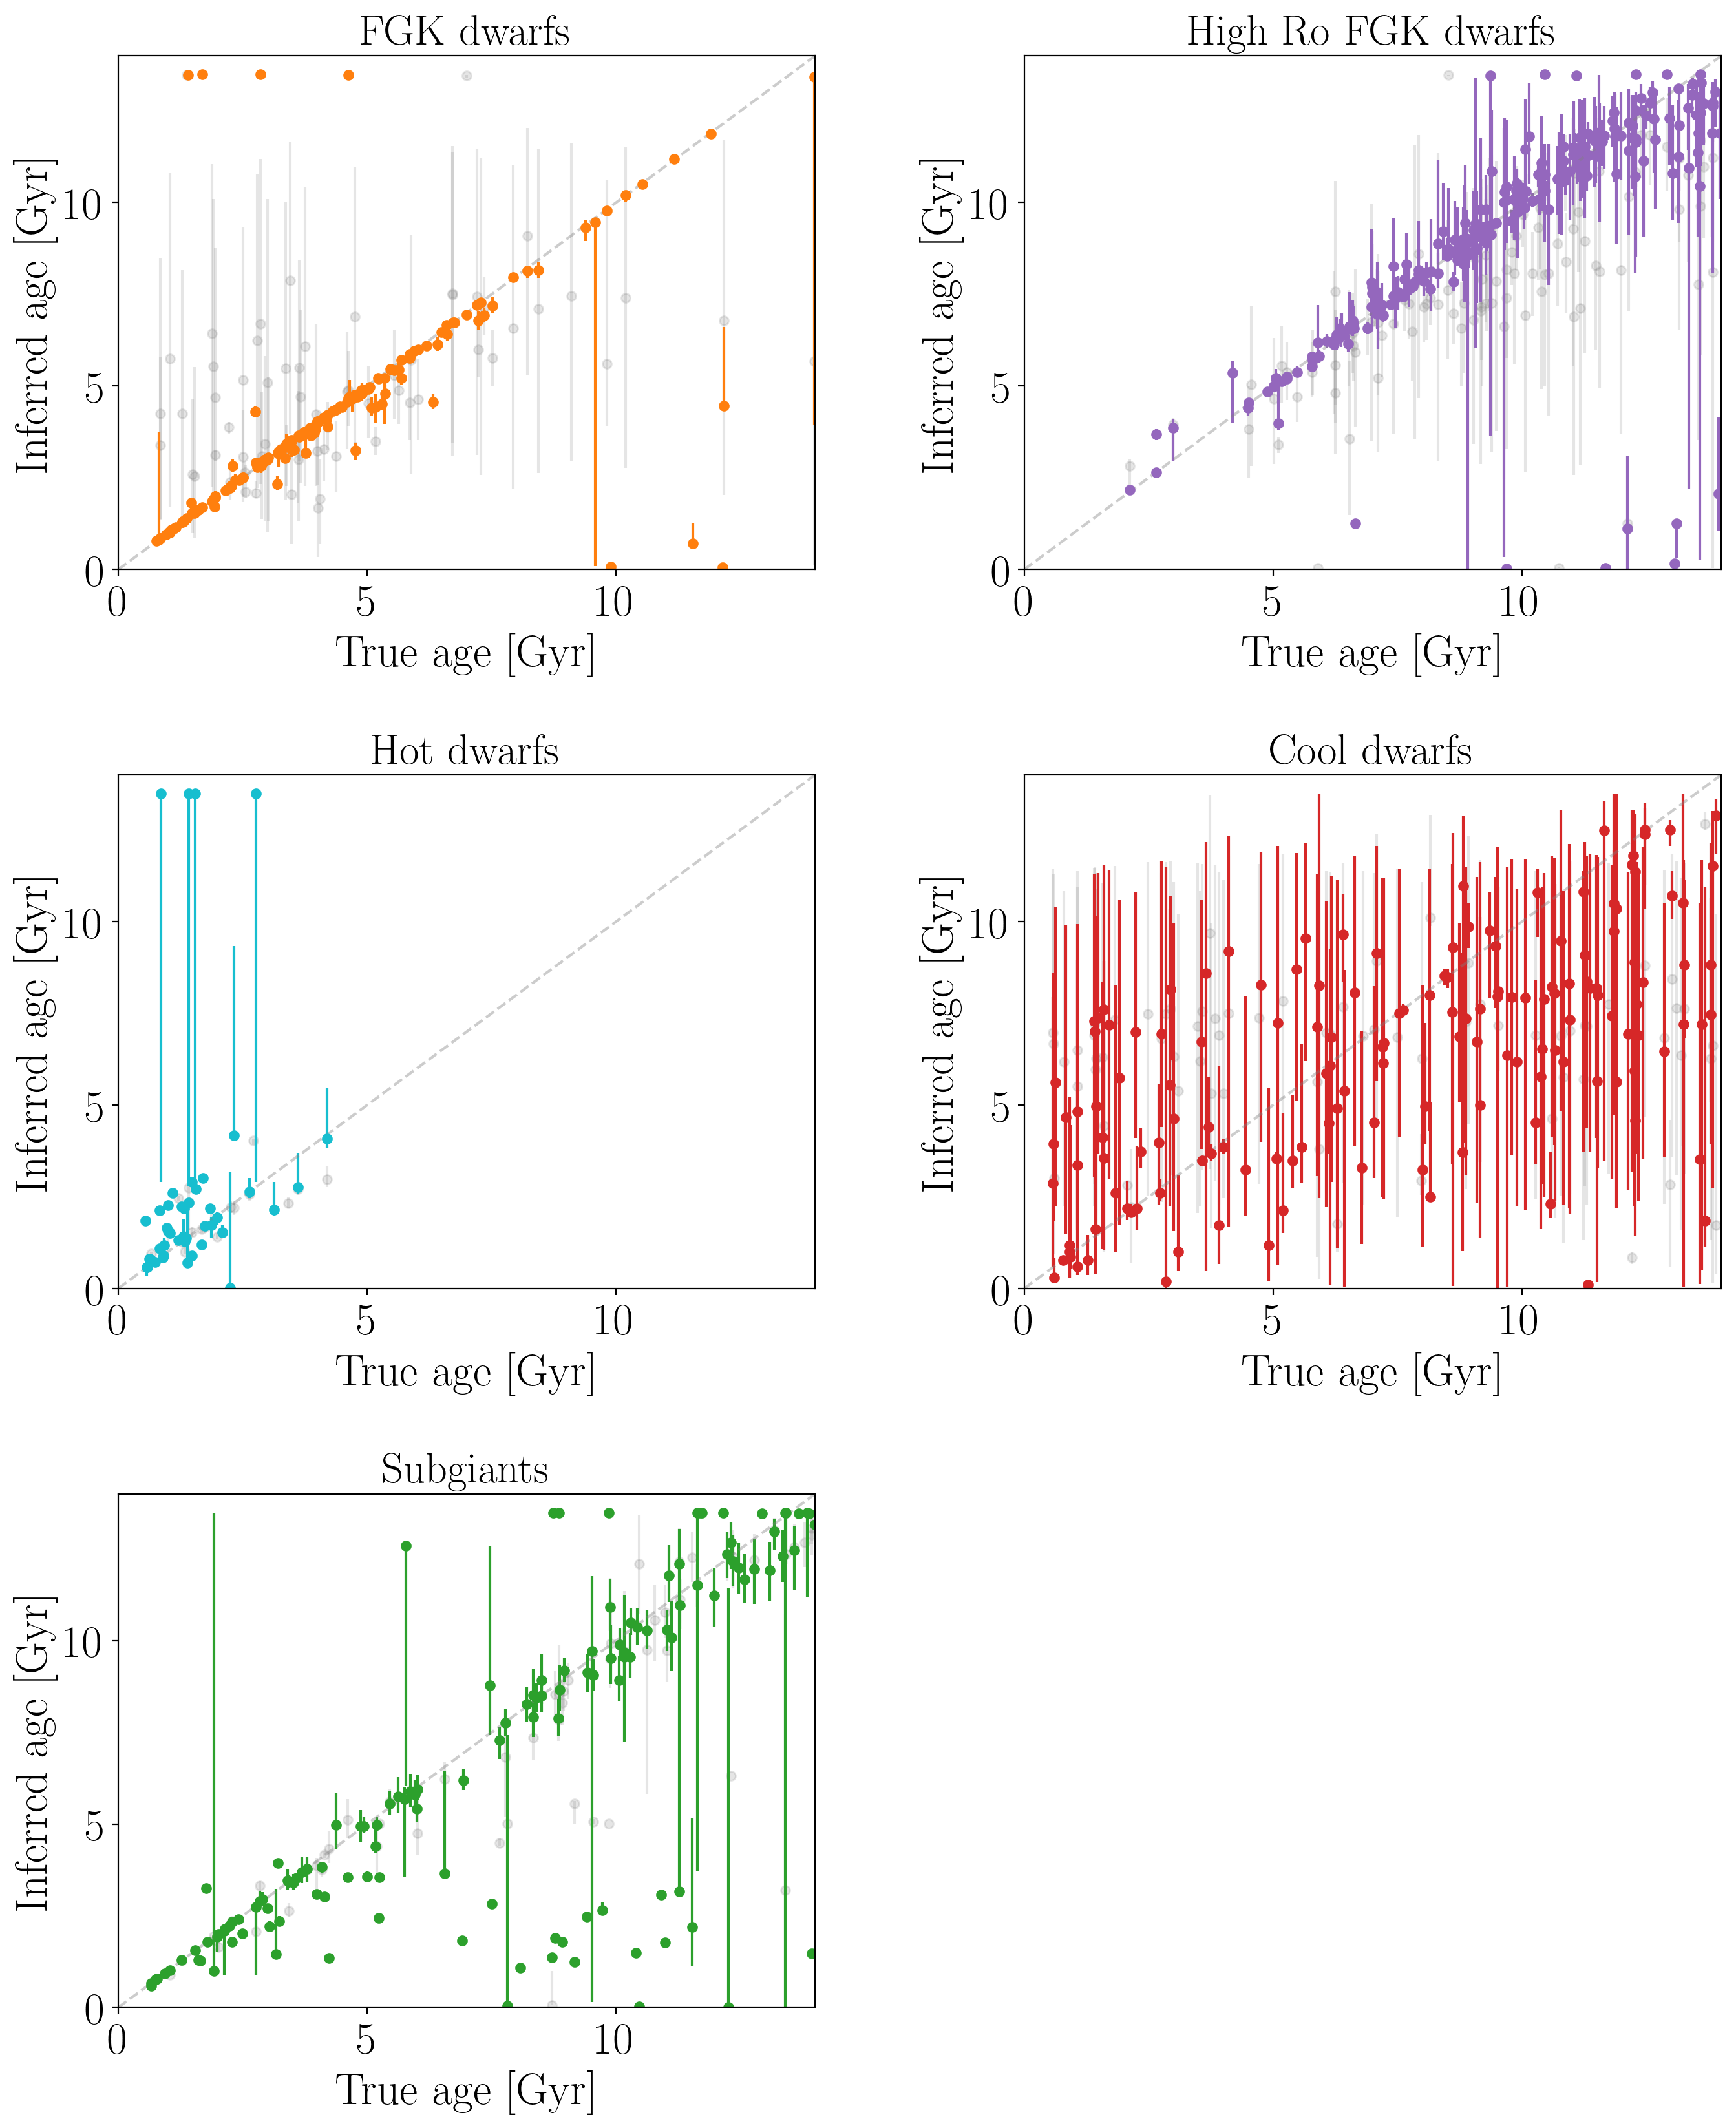

In [305]:
plotpar = {'axes.labelsize': 25,
           'font.size': 20,
           'legend.fontsize': 12,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 20), dpi=200)
plt.subplot(3, 2, 1)

plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="tab:orange")
plt.errorbar(true_age_gyr[iinds][ifgk], imeds[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{FGK~dwarfs}$")

plt.subplot(3, 2, 2)
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
             color="tab:purple", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][irossbied], imeds[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{High~Ro~FGK~dwarfs}$")

plt.subplot(3, 2, 3)
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
             color="tab:cyan", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][ihot], imeds[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Hot~dwarfs}$")

plt.subplot(3, 2, 4)
plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][icool], imeds[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14) 
plt.title("$\mathrm{Cool~dwarfs}$")

plt.subplot(3, 2, 5)
plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{{stardate}}$", rasterized=True, color="tab:green")
plt.errorbar(true_age_gyr[iinds][ievolved], imeds[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend(loc="lower right")
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Subgiants}$")

plt.subplots_adjust(wspace=.3, hspace=.4)
plt.savefig("../simulation_results.pdf")
plt.savefig("simulation_results")

Now gyrochronology only.

In [306]:
gage_samps, gmeds, gerrp, gerrm, gstd, ginds = read_files("gyro", np.arange(1000), dirname="simulation_results")
gfgk, ghot, gcool, gevolved, grossbied = selection(df, ginds)

Text(0, 0.5, '$\\log(g)$')

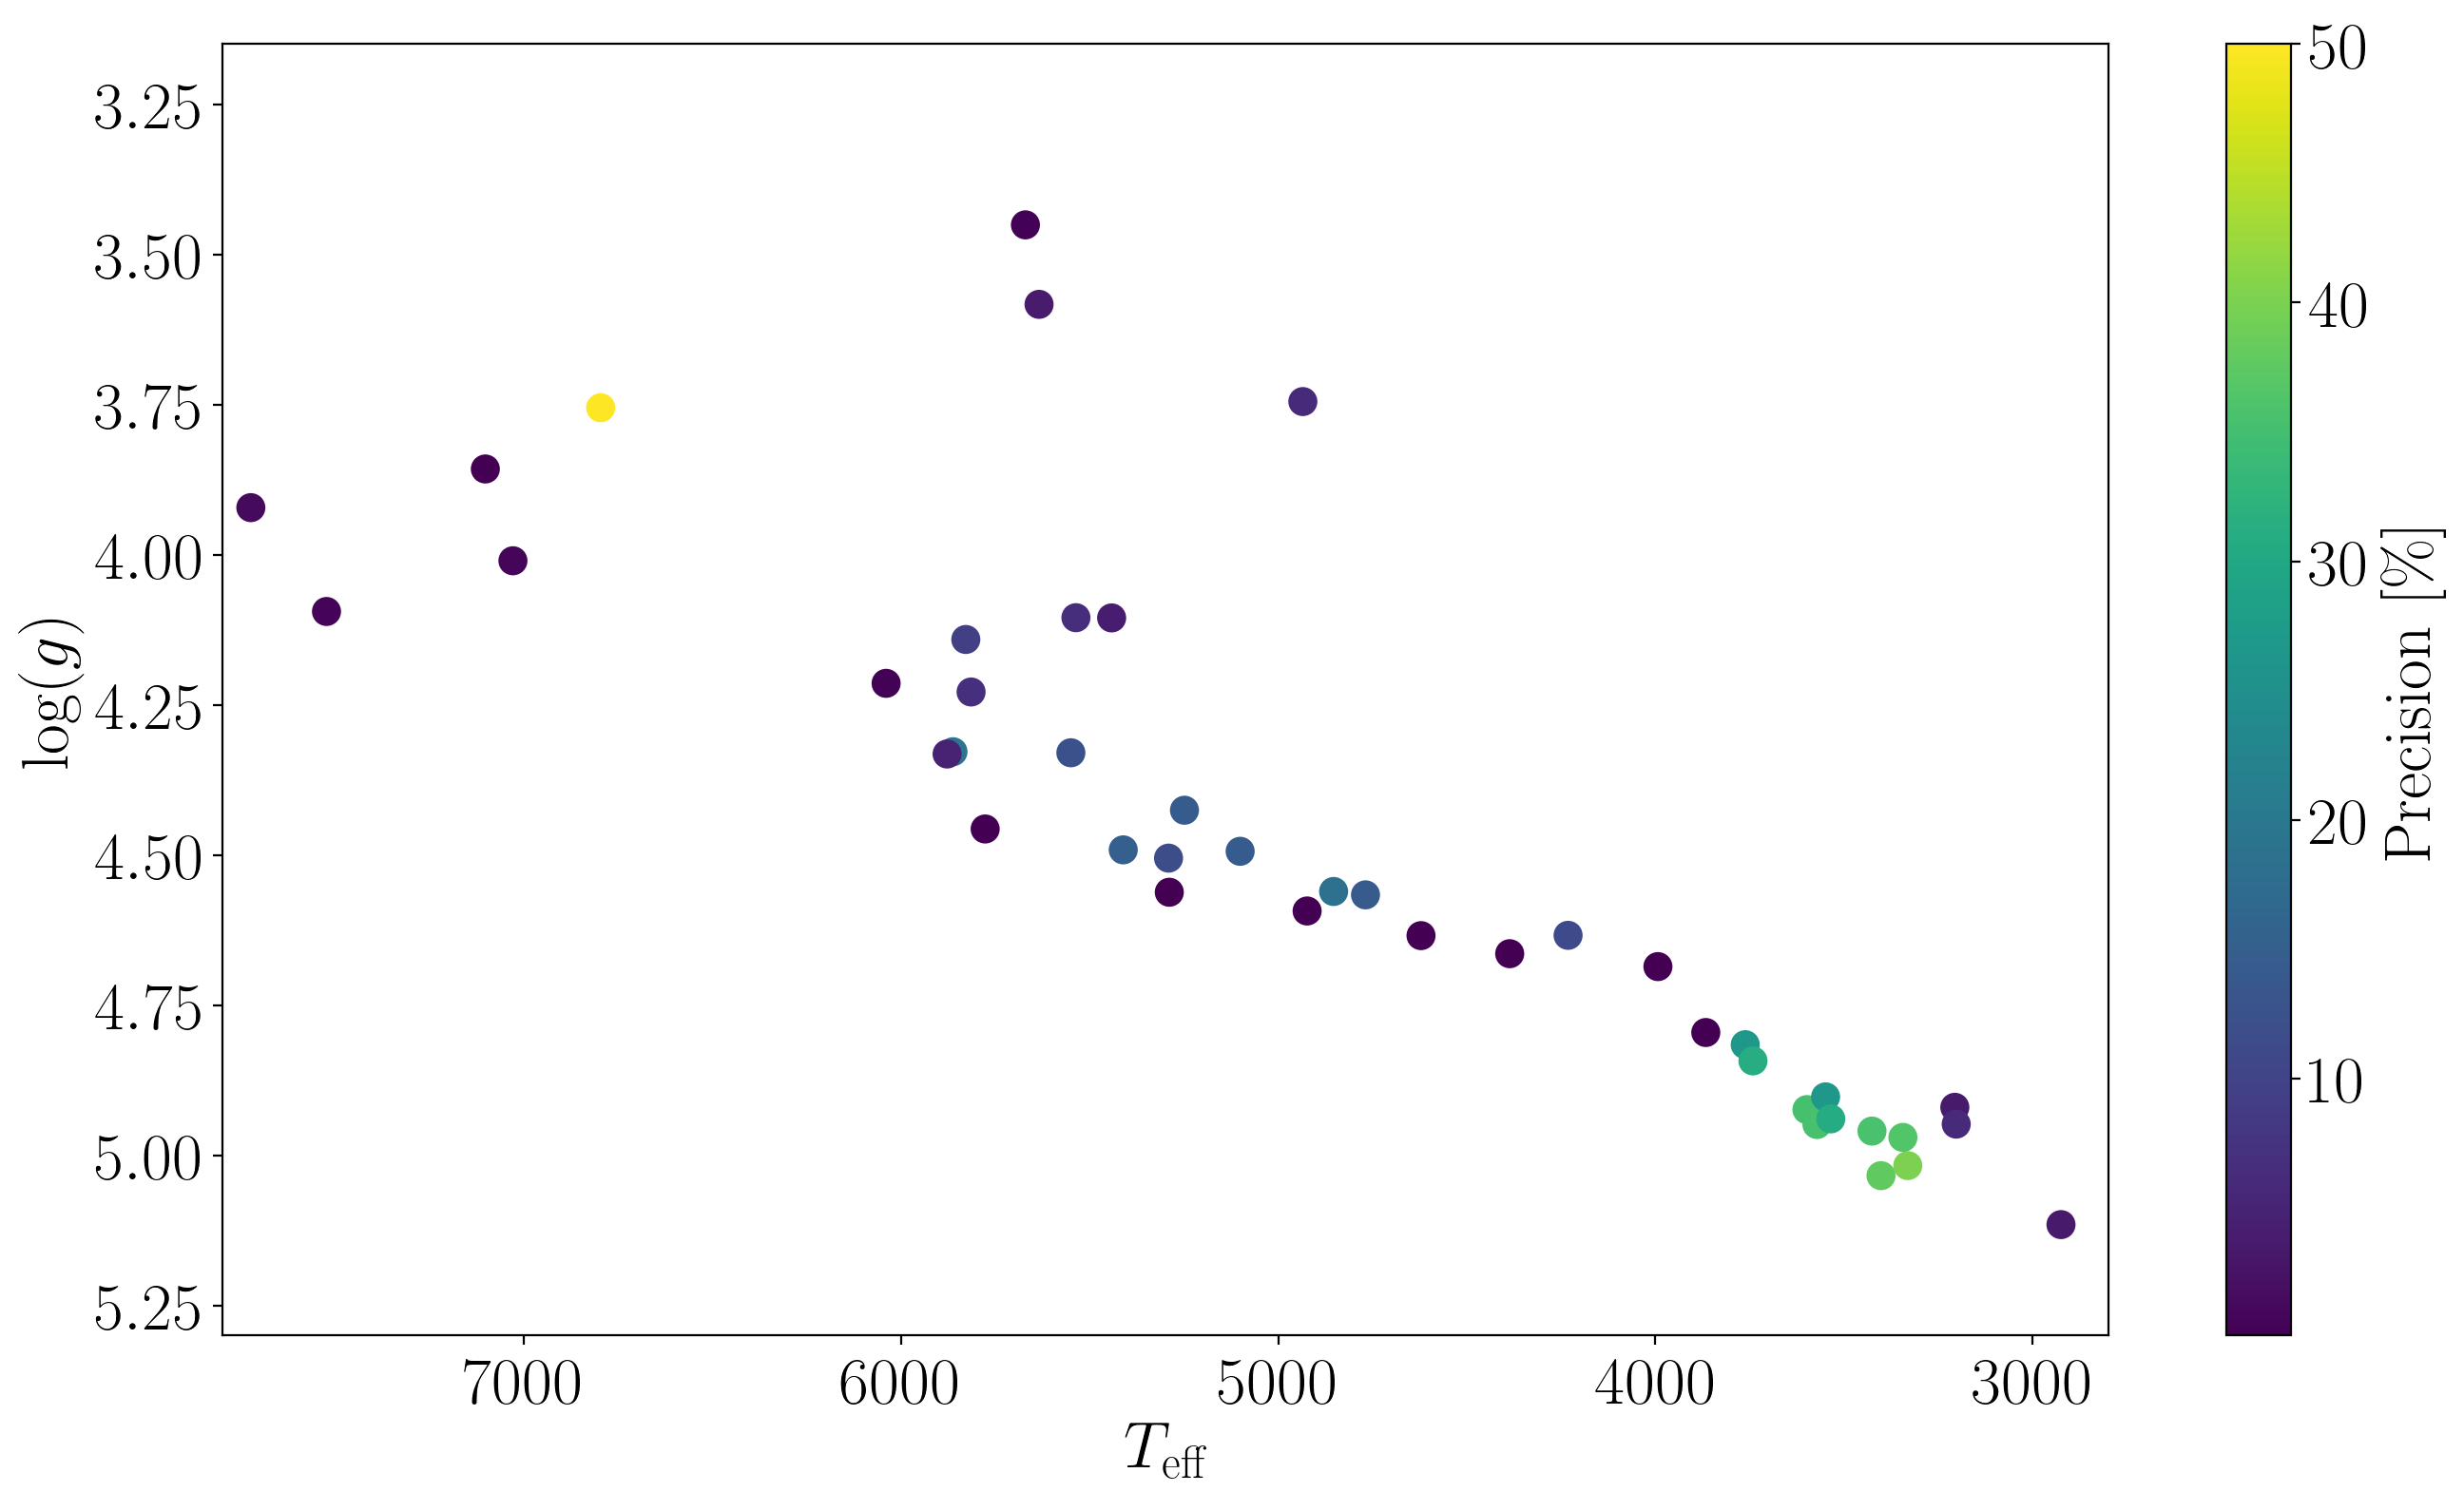

In [307]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[ginds], df.logg.values[ginds],
            c=(gstd/df.age.values[ginds])*100, s=100, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Text(0, 0.5, '$\\log(g)$')

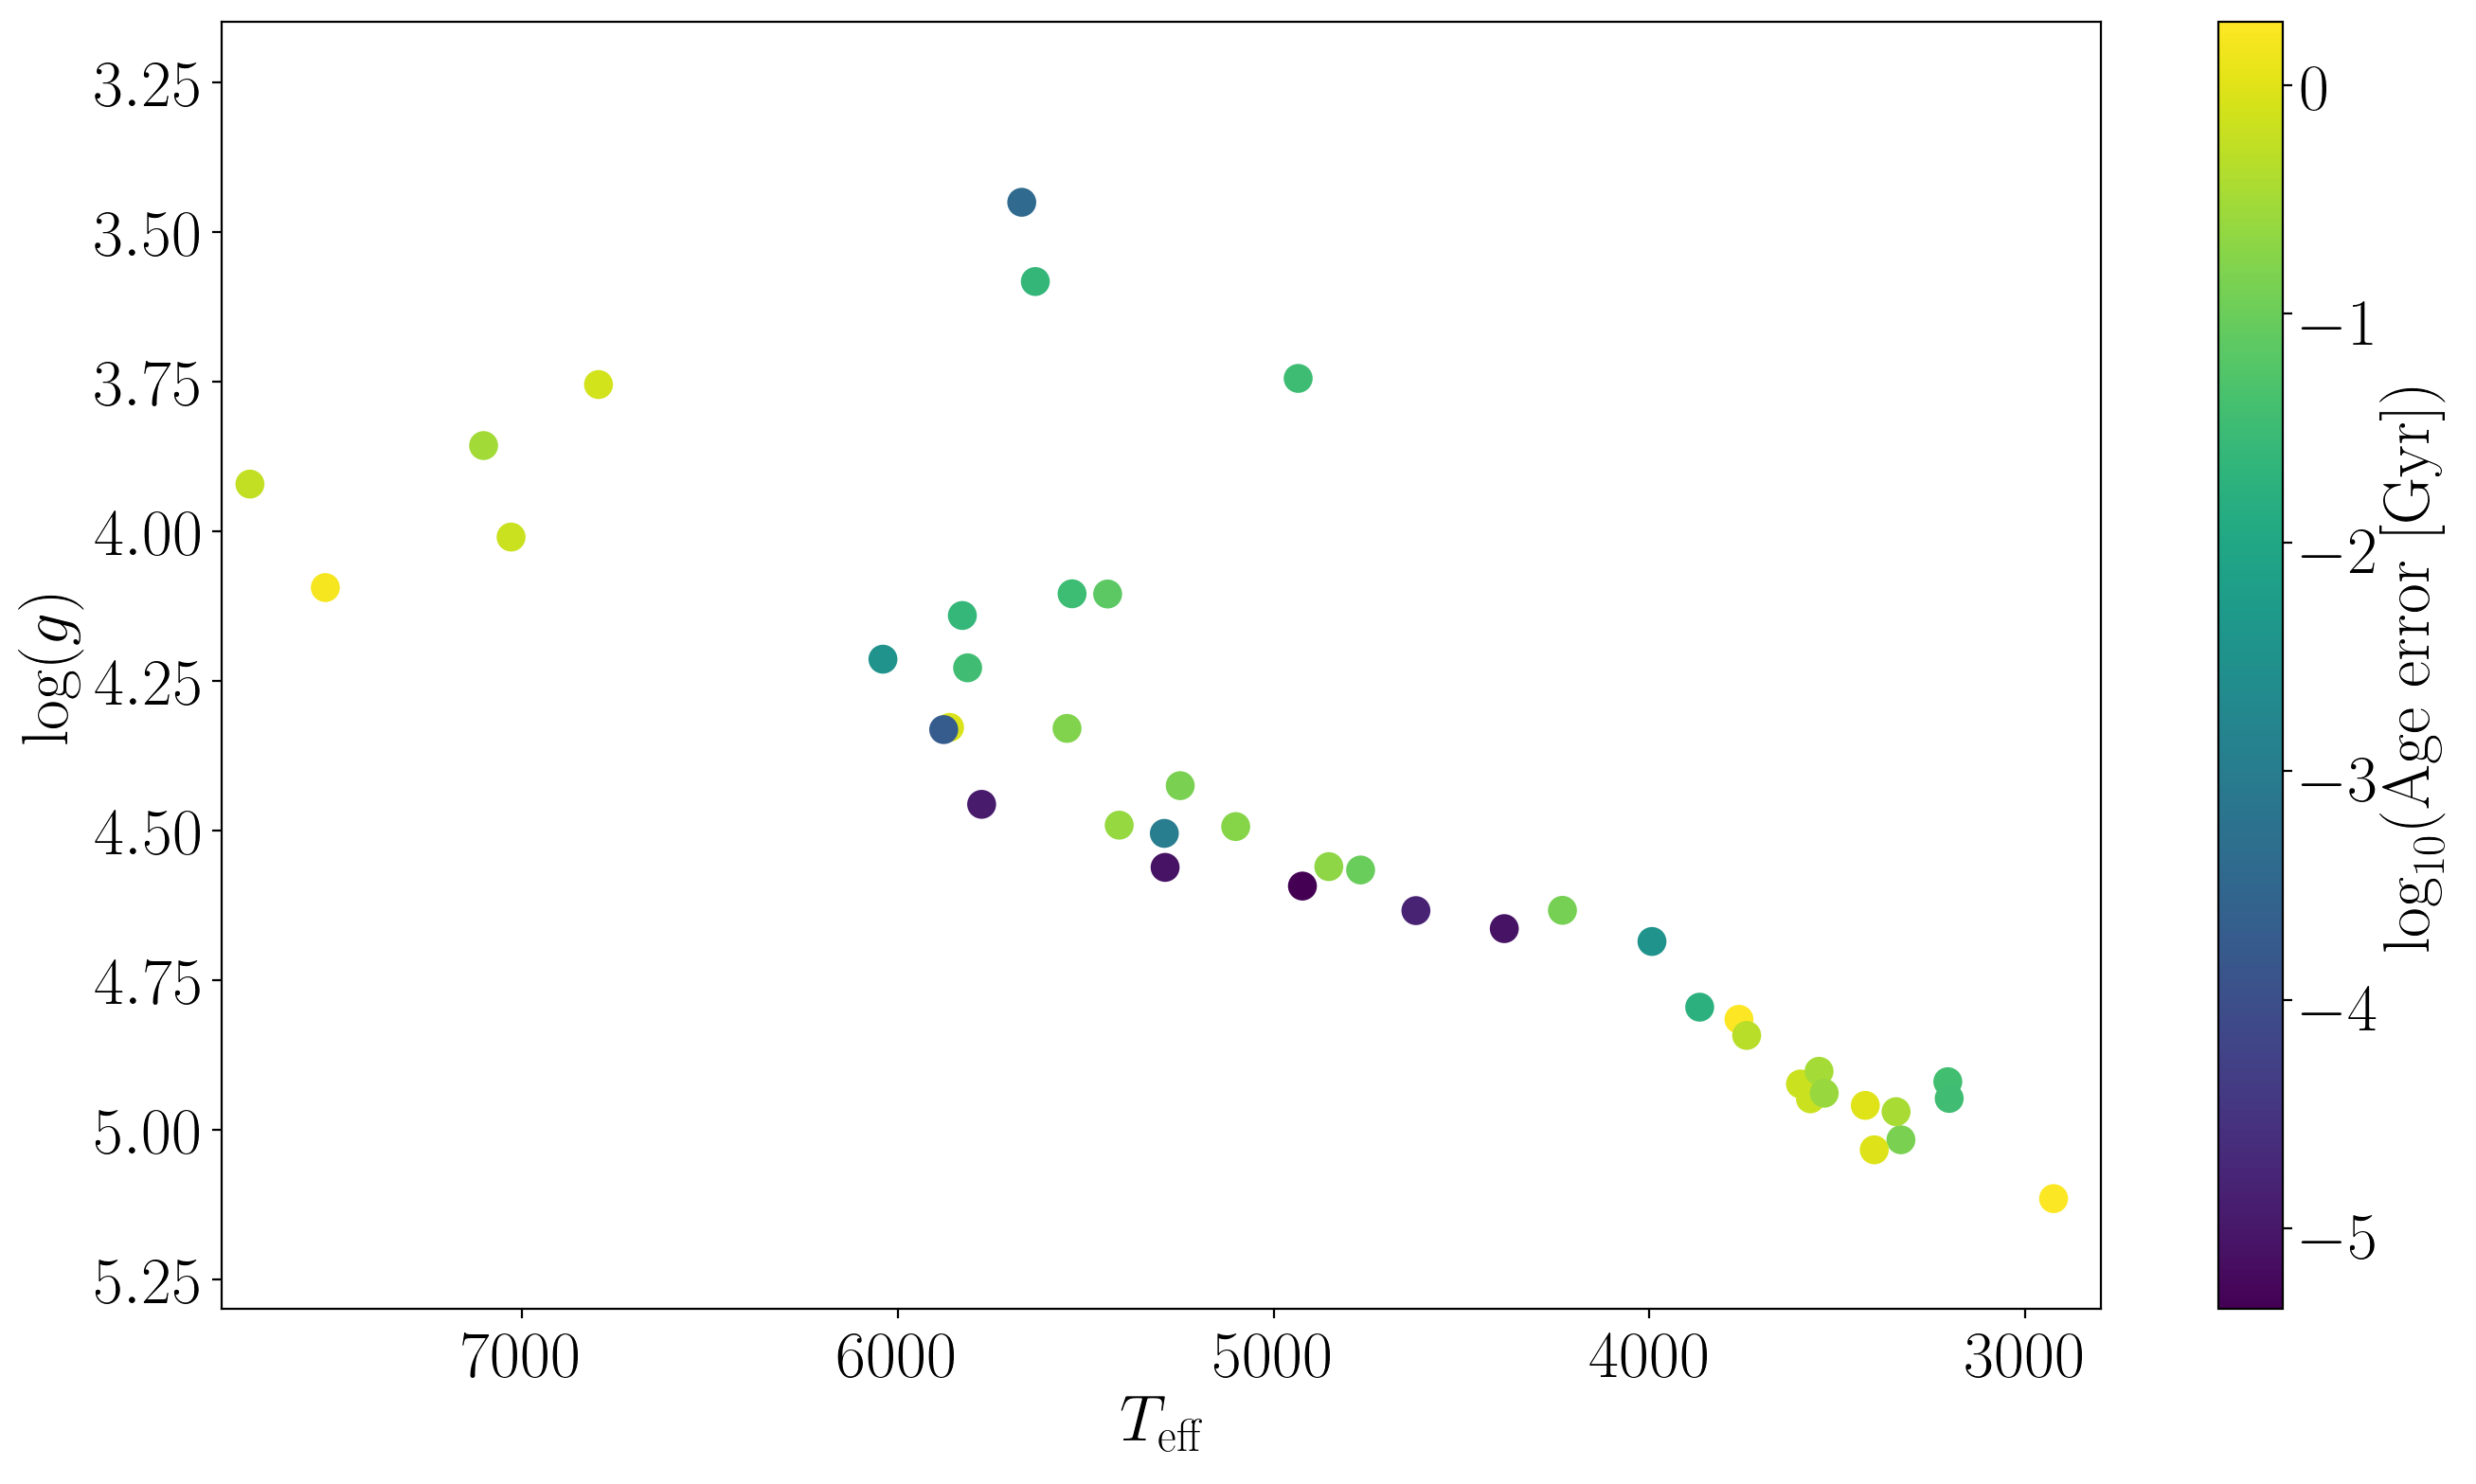

In [308]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[ginds], df.logg.values[ginds],
            c=np.log10(abs(true_age_gyr[ginds] - gmeds)/true_age_gyr[ginds]), s=100)
plt.colorbar(label="$\mathrm{\log_{10}(Age~error~[Gyr])}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Calculate precision for stardate.

In [309]:
def precision(stds, meds):
    return np.median(stds/meds)*100

def accuracy(true, meds):
    return np.median(abs(meds - true))*1e3

def rel_acc(true, meds):
    return np.median((abs(meds - true)/meds)*100)

print("median FGK age precision = {:.2f} %".format(precision(std[fgk], meds[fgk])))
print("median FGK absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][fgk], meds[fgk])))
print("median FGK relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][fgk], meds[fgk])))

print("\nmedian high Ro age precision = {:.2f} %".format(precision(std[rossbied], meds[rossbied])))
print("median high Ro absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][rossbied], 
                                                                          meds[rossbied])))
print("median high Ro relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][rossbied], 
                                                                          meds[rossbied])))

print("\nmedian hot age precision = {:.2f} %".format(precision(std[hot], meds[hot])))
print("median hot absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][hot], meds[hot])))
print("median hot relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][hot], meds[hot])))

print("\nmedian cool age precision = {:.2f} %".format(precision(std[cool], meds[cool])))
print("median cool absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][cool], meds[cool])))
print("median cool relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][cool], meds[cool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(std[evolved], meds[evolved])))
print("median subgiant absolute age error = {:.2f} Myr".format(accuracy(true_age_gyr[inds][evolved], 
                                                                           meds[evolved])))
print("median subgiant relative age error = {:.2f} %".format(rel_acc(true_age_gyr[inds][evolved], 
                                                                           meds[evolved])))

median FGK age precision = 3.25 %
median FGK absolute age error = 27.25 Myr
median FGK relative age error = 0.73 %

median high Ro age precision = 8.49 %
median high Ro absolute age error = 248.26 Myr
median high Ro relative age error = 2.56 %

median hot age precision = 14.96 %
median hot absolute age error = 563.48 Myr
median hot relative age error = 36.36 %

median cool age precision = 49.55 %
median cool absolute age error = 2298.04 Myr
median cool relative age error = 37.09 %

median subgiant age precision = 7.60 %
median subgiant absolute age error = 468.66 Myr
median subgiant relative age error = 6.24 %


Calculate precision for isochrone fitting.

In [310]:
print("median FGK age precision = {:.2f} %".format(precision(istd[ifgk], imeds[ifgk])))
print("median FGK absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ifgk], imeds[ifgk])))
print("median FGK relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][ifgk], imeds[ifgk])))

print("\nmedian high Ro age precision = {:.2f} %".format(precision(istd[irossbied], imeds[irossbied])))
print("median high Ro absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][irossbied], 
                                                                          imeds[irossbied])))
print("median high Ro relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][irossbied], 
                                                                          imeds[irossbied])))

print("\nmedian hot age precision = {:.2f} %".format(precision(istd[ihot], imeds[ihot])))
print("median hot absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ihot], imeds[ihot])))
print("median hot relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][ihot], imeds[ihot])))

print("\nmedian cool age precision = {:.2f} %".format(precision(istd[icool], imeds[icool])))
print("median cool absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][icool], imeds[icool])))
print("median cool relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][icool], imeds[icool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(istd[ievolved], imeds[ievolved])))
print("median subgiant absolute age accuracy = {:.2f} Myr".format(accuracy(true_age_gyr[iinds][ievolved], 
                                                                           imeds[ievolved])))
print("median subgiant relative age accuracy = {:.2f} Myr".format(rel_acc(true_age_gyr[iinds][ievolved], 
                                                                           imeds[ievolved])))

median FGK age precision = 49.19 %
median FGK absolute age accuracy = 1311.87 Myr
median FGK relative age accuracy = 30.49 Myr

median high Ro age precision = 21.89 %
median high Ro absolute age accuracy = 1296.81 Myr
median high Ro relative age accuracy = 16.22 Myr

median hot age precision = 9.48 %
median hot absolute age accuracy = 510.40 Myr
median hot relative age accuracy = 33.16 Myr

median cool age precision = 56.04 %
median cool absolute age accuracy = 3980.54 Myr
median cool relative age accuracy = 56.55 Myr

median subgiant age precision = 8.06 %
median subgiant absolute age accuracy = 581.83 Myr
median subgiant relative age accuracy = 7.50 Myr


In [312]:
print("median age precision = {0}%".format(precision(std, meds)))
print("median age error = {0}%".format(accuracy(true_age_gyr[inds], meds)))
print("median age relative error = {0}%".format(rel_acc(true_age_gyr[inds], meds)))

print("\nmedian age precision = {0}%".format(precision(istd, imeds)))
print("median age error = {0}%".format(accuracy(true_age_gyr[iinds], imeds)))
print("median age relative error = {0}%".format(rel_acc(true_age_gyr[iinds], imeds)))

median age precision = 10.786679658339096%
median age error = 343.123562901857%
median age relative error = 4.366575418476345%

median age precision = 28.380660165097854%
median age error = 1285.728567975272%
median age relative error = 23.16070732862349%


Load Praesepe posteriors.

In [527]:
pr = pd.read_csv("data/praesepe.csv")
finite = np.isfinite(pr.bp.values - pr.rp.values) * np.isfinite(pr.G.values)
pr = pr.iloc[finite]

page_samps, pmeds, perrp, perrm, pstds, pinds = read_files("praesepe_angus", pr.EPIC.values,
                                                           dirname="praesepe_results")
ipage_samps, ipmeds, iperrp, iperrm, ipstds, ipinds = read_files("praesepe_iso", pr.EPIC.values,
                                                           dirname="praesepe_results")

In [530]:
print(len(pmeds))

397


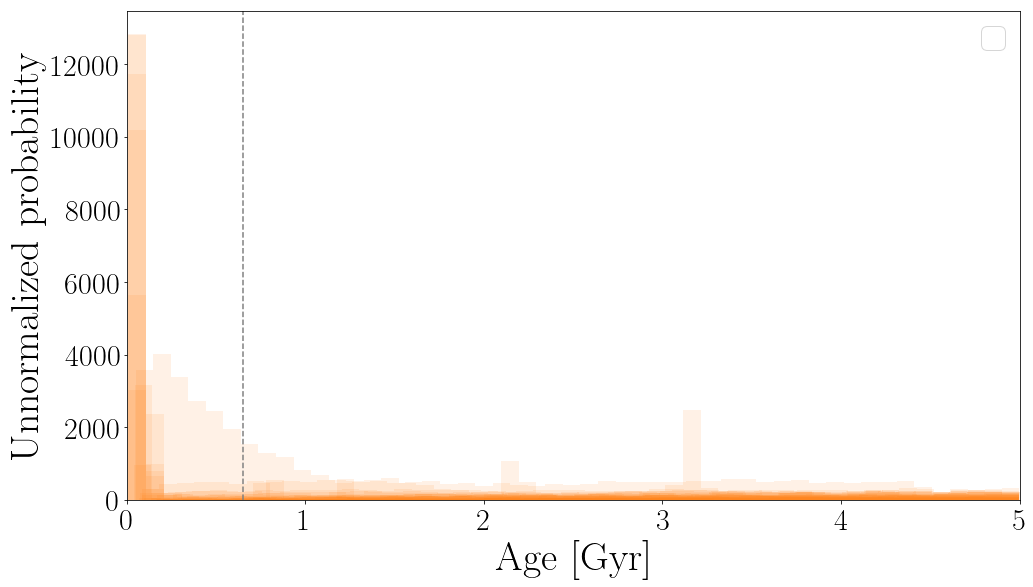

In [535]:
import scipy.stats as sps

xs = np.linspace(0, 5, 50)

plt.figure(figsize=(16, 9)) 

i = 0
mask = np.array(page_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(page_samps)[i][mask])
# plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                  rasterized=True, label="$\mathrm{{\it stardate}~ages~[Gyr]}$")
# plt.hist(page_samps[i][mask], alpha=.1, color="C0");

for i, samps in enumerate(page_samps):
    mask = np.array(page_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(page_samps)[i][mask])
#     plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                      rasterized=True)
    plt.hist(samps[mask], 50, alpha=.1, color="C0");
    
i = 0
mask = np.array(ipage_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(ipage_samps)[i][mask])
# plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.2, zorder=1,
#                  rasterized=True, label="$\mathrm{Isochrone~ages~[Gyr]}$")
# plt.hist(ipage_samps[i][mask], alpha=.1, color="C0");

for i, samps in enumerate(ipage_samps):
    mask = np.array(ipage_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(ipage_samps)[i][mask])
#     plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.2, zorder=1,
#                      rasterized=True)
    plt.hist(samps[mask], 50, alpha=.1, color="C1");

    
plt.xlim(0, 5)
plt.axvline(.65, color=".5", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.legend()
# plt.ylim(0, 30)
plt.savefig("../praesepe_results.pdf")

(15, 2)

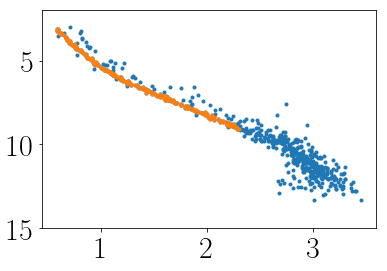

In [521]:
import scipy.optimize as spo

def abs_mag(G, D):
    return - 5*np.log10(D) + 5 + G

def model(p, x):
    return np.polyval(p, x)

def nll(p, x, y, yerr):
    return -sum(-.5*(y - model(p, x))**2/yerr**2)

def clip(x, y, yerr):
    pinit = np.ones(5)
    results = spo.minimize(nll, pinit, args=(x, y, yerr))
    p = results.x

    inds = np.arange(len(x))
    for i in range(10):
        results = spo.minimize(nll, p, args=(x, y, yerr));
        p = results.x
        std = np.std(y - model(p, x))
        m = abs(y - model(p, x)) > 3*std
        x, y, yerr = x[~m], y[~m], yerr[~m]
        inds = inds[~m]
    return x, y, yerr, p, inds

cool = pr.bp.values - pr.rp.values < 2.3

abs_G = abs_mag(pr.G.values, (1./pr.parallax.values)*1e3)
_x, _y, _yerr, _p, _inds = clip(pr.bp.values[cool]-pr.rp.values[cool],
                                abs_G[cool], np.ones(len(abs_G[cool]))*.001)

binary_flag = np.zeros(len(pr.G.values[cool]), dtype=bool)
binary_flag[_inds] = np.ones(len(binary_flag[_inds]), dtype=bool)

plt.plot(pr.bp.values-pr.rp.values, abs_G, ".")
plt.plot(_x, _y, ".")
plt.ylim(15, 2)

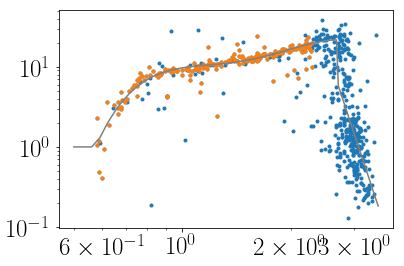

In [408]:
from stardate.lhf import gyro_model_praesepe

plt.plot(bprp.values, pr.prot.values, ".")
plt.plot(bprp.values[fm][m][_inds], pr.prot.values[fm][m][_inds], ".")
xs = np.linspace(.5, 3.5, 100)
ps = np.zeros(len(xs))
for i, x in enumerate(xs):
    ps[i] = gyro_model_praesepe(np.log10(650*1e6), x)
plt.loglog(xs, 10**ps, color=".5")
plt.yscale("log")

In [414]:
page_samps, pmeds, perrp, perrm, pstds, pinds = read_files("praesepe_stardate", pr.EPIC.values,
                                                           dirname="praesepe_results")
print(len(pmeds), "stars")

204 stars


In [415]:
piage_samps, pimeds, pierrp, pierrm, pistds, piinds = read_files("praesepe_iso", pr.EPIC.values,
                                                                 dirname="praesepe_results");
print(len(pimeds), "stars")

23 stars


In [416]:
pgage_samps, pgmeds, pgerrp, pgerrm, pgstds, pginds = read_files("praesepe_gyro", pr.EPIC.values,
                                                                 dirname="praesepe_results")
print(len(pgmeds), "stars")

146 stars


In [418]:
def find_single_measured_inds(pr, measured_inds, meds, errp, errm, std, single_epics):
    epics_measured = pr.iloc[measured_inds]
    epics_measured["age"] = np.array(meds)
    epics_measured["age_errp"] = np.array(errp)
    epics_measured["age_errm"] = np.array(errm)
    epics_measured["age_err"] = np.array(std)
    epics_measured["i"] = np.arange(len(meds))
    final_df = pd.merge(epics_measured, single_epics, on="EPIC", how="inner").drop_duplicates()
    return final_df
    
single_epics = pd.DataFrame(dict({"EPIC": pr.EPIC.values[fm][m][_inds]}))
pdf = find_single_measured_inds(pr, pinds, pmeds, perrp, perrm, pstds, single_epics)
idf = find_single_measured_inds(pr, piinds, pimeds, pierrp, pierrm, pistds, single_epics)
gdf = find_single_measured_inds(pr, pginds, pgmeds, pgerrp, pgerrm, pgstds, single_epics)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

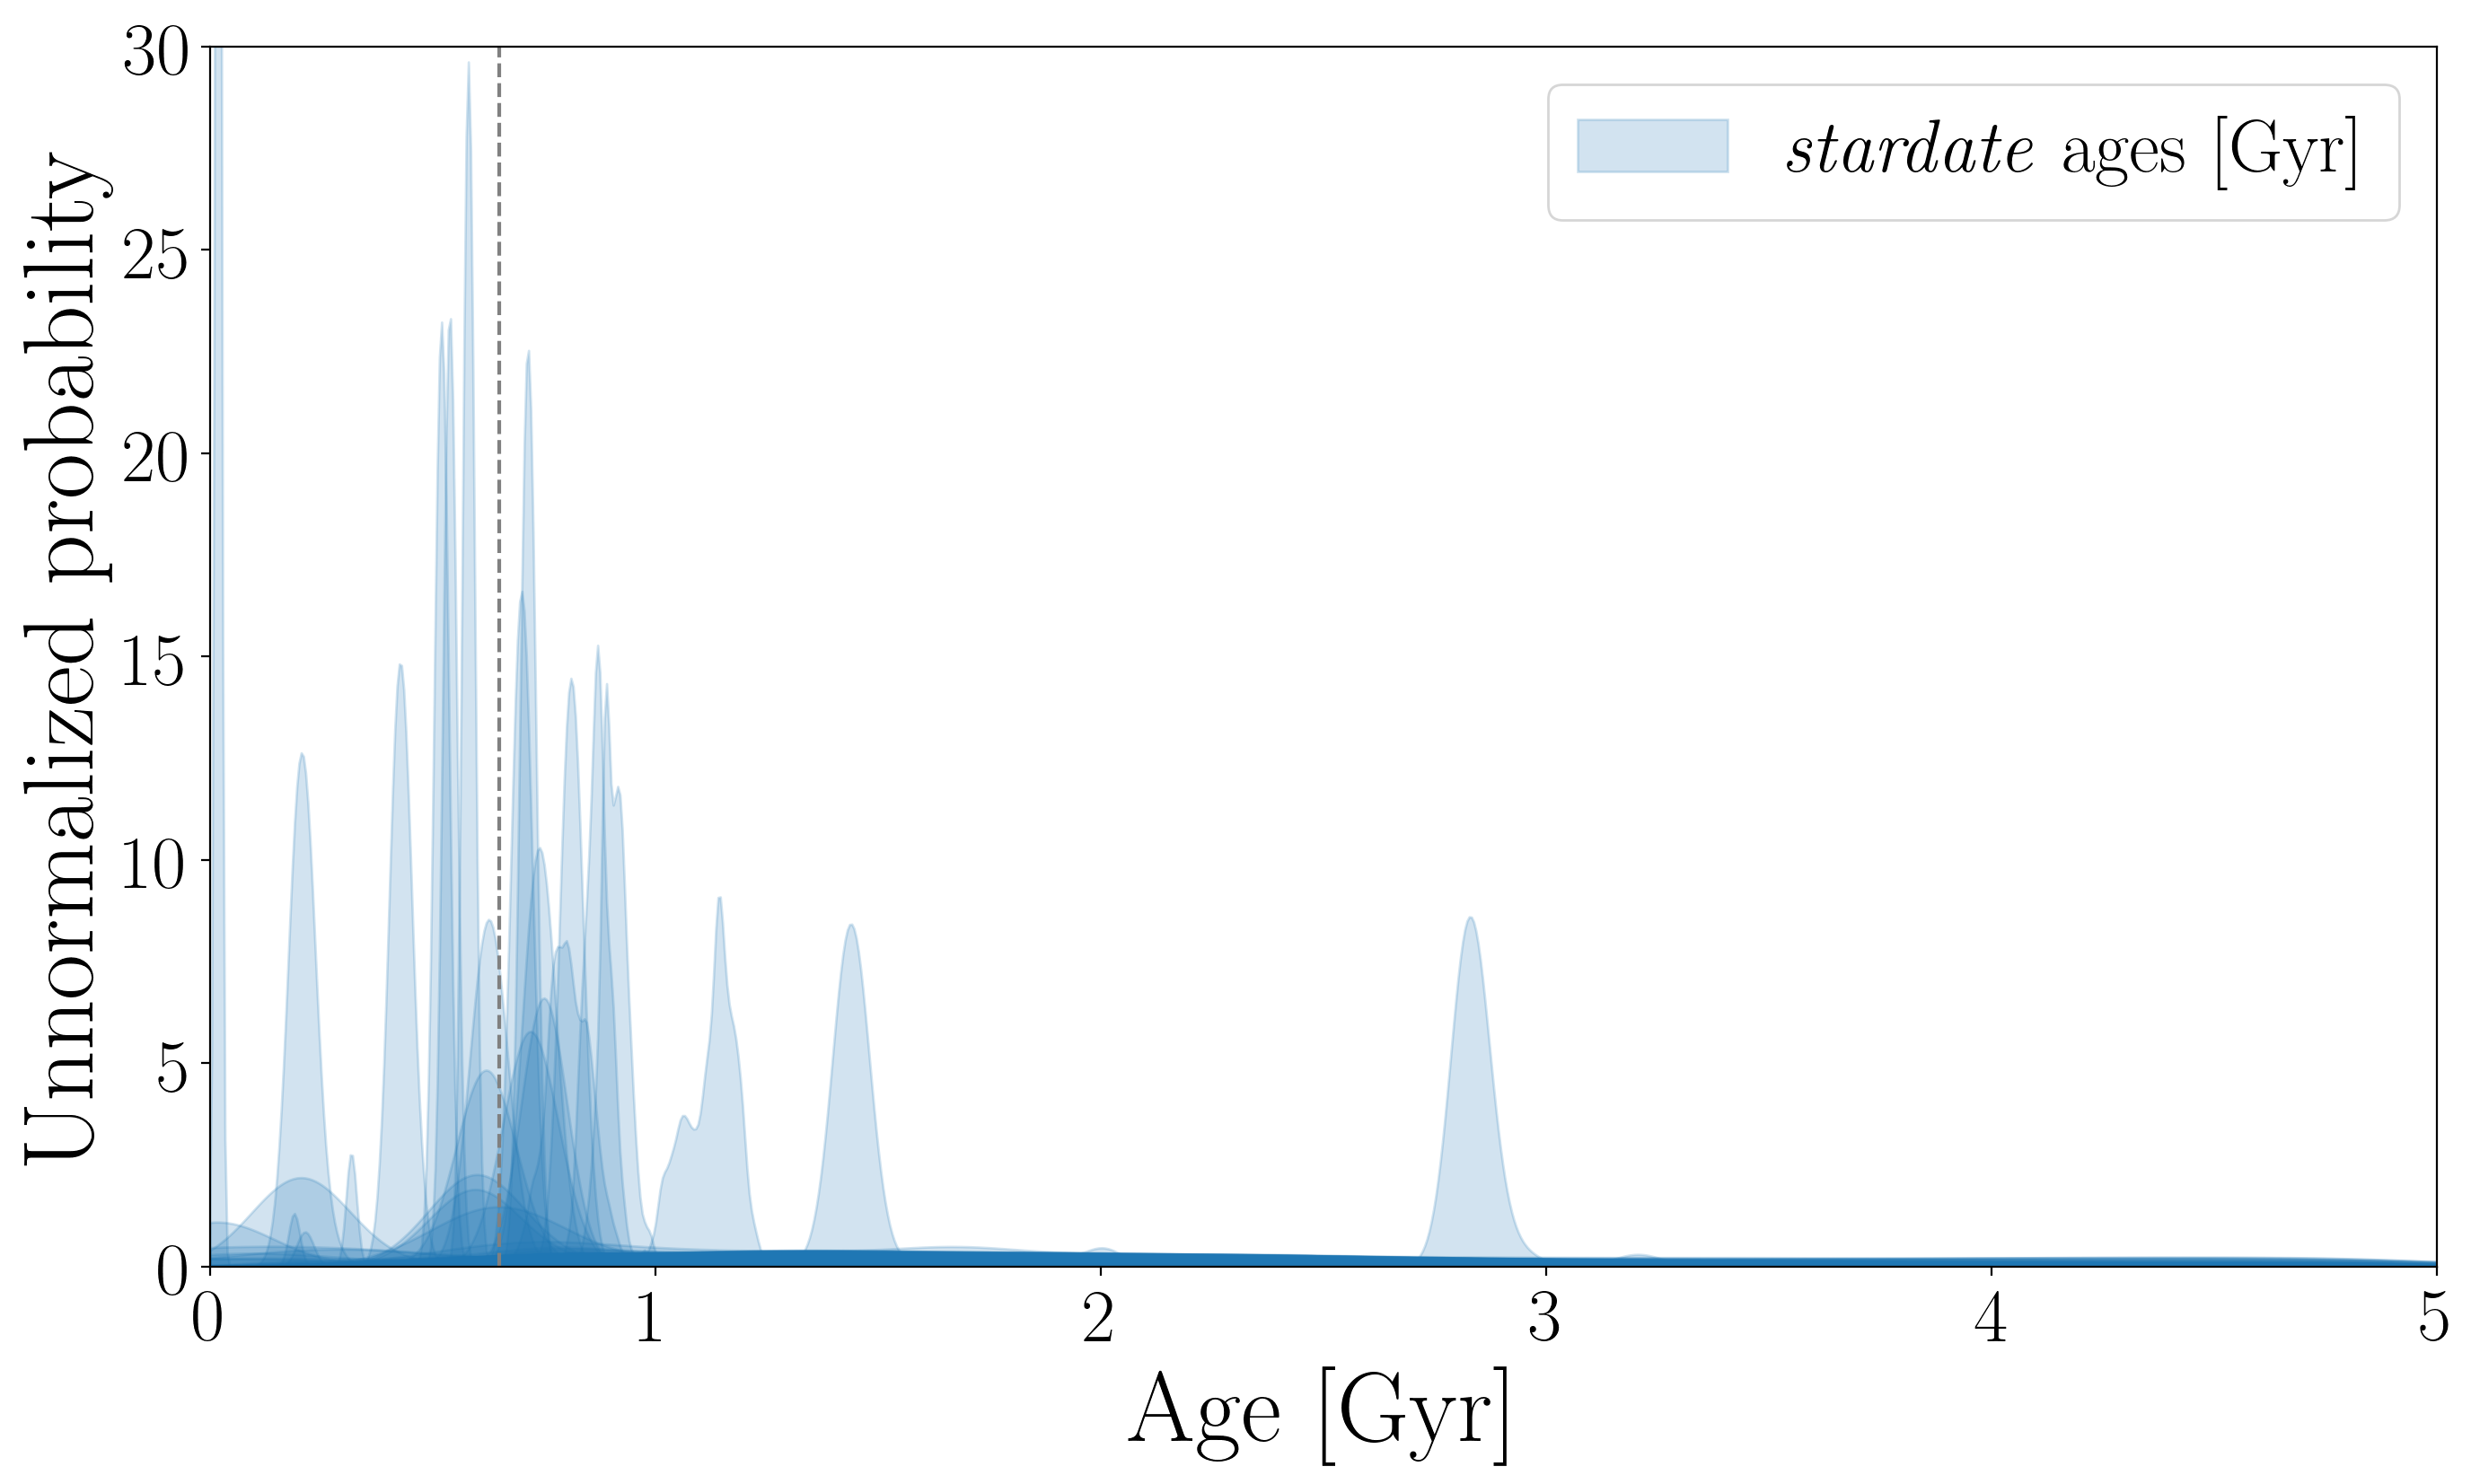

In [458]:
import scipy.stats as sps

xs = np.linspace(0, 5, 1000)

plt.figure(figsize=(16, 9), dpi=200)
    
# for i in gdf.i.values:
#     mask = np.array(pgage_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(pgage_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C2", alpha=.1, zorder=0)    

# i = pdf.i.values[0]
# mask = np.array(page_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(page_samps[i][mask]))
# plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                      rasterized=True, label="$\mathrm{{\it stardate}~ages~[Gyr]}$")

# for i in pdf.i.values[1:]:
#     mask = np.array(page_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(page_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
#                      rasterized=True)

# i = idf.i.values[0]
# mask = np.array(piage_samps)[i] < 5
# kernel = sps.gaussian_kde(np.array(piage_samps[i][mask]))
# plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.5, zorder=2,
#                      rasterized=True, label="$\mathrm{Isochrone~ages~[Gyr]}$")
    
# for i in idf.i.values[1:]:
#     mask = np.array(piage_samps)[i] < 5
#     kernel = sps.gaussian_kde(np.array(piage_samps[i][mask]))
#     plt.fill_between(xs, 0, kernel(xs), color="C1", alpha=.5, zorder=2,
#                      rasterized=True)
    
plt.xlim(0, 5)
plt.axvline(.65, color=".5", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.legend()
plt.ylim(0, 30)
plt.savefig("../praesepe_results.pdf")

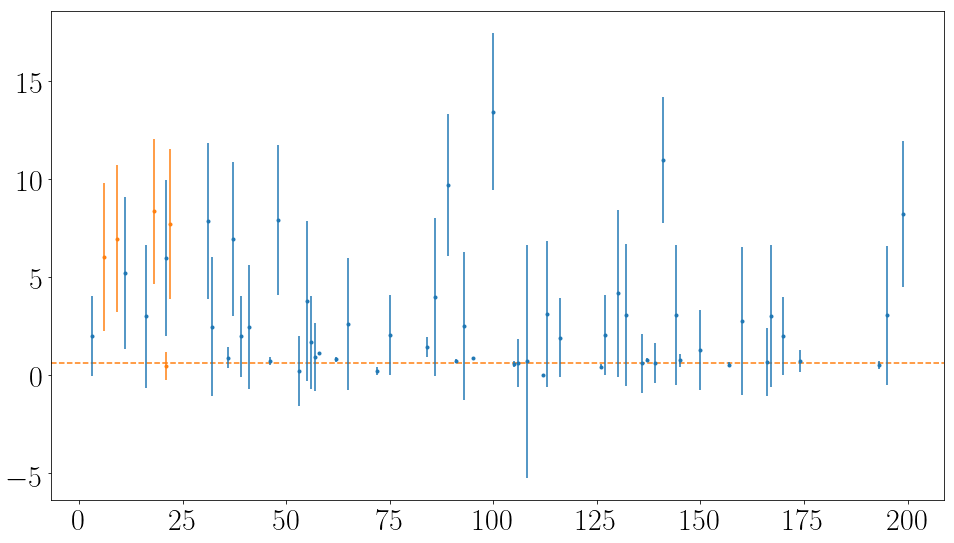

In [454]:
plt.figure(figsize=(16, 9))
plt.axhline(0.65, color="C1", ls="--", zorder=0)
for i, j in enumerate(pdf.i.values):
    plt.errorbar(j, pdf.age.values[i], yerr=pdf.age_err.values[i], fmt=".", color="C0", zorder=1)
    
for i, j in enumerate(idf.i.values):
    plt.errorbar(j, idf.age.values[i], yerr=idf.age_err.values[i], fmt=".", color="C1", zorder=1)
# plt.errorbar(np.arange(len(idf)), idf.age, yerr=[idf.age_errp, idf.age_errm], fmt=".", zorder=1)

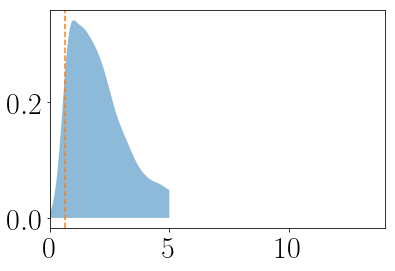

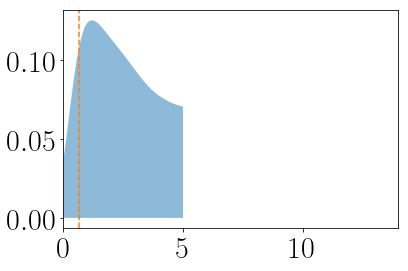

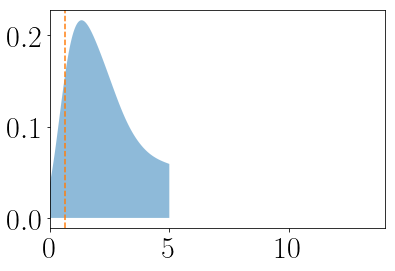

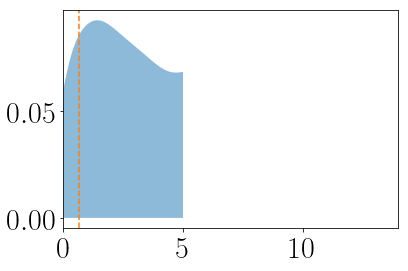

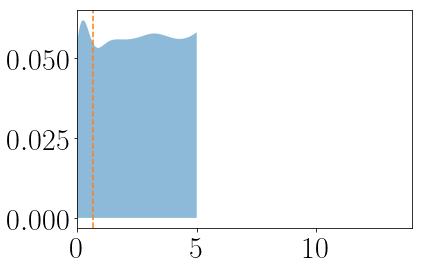

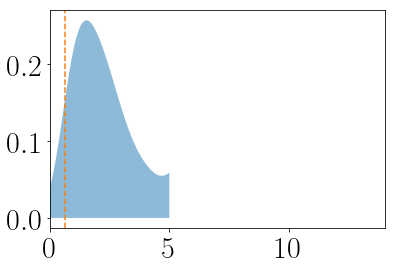

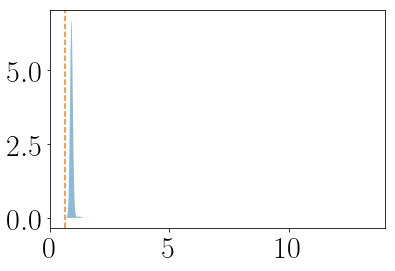

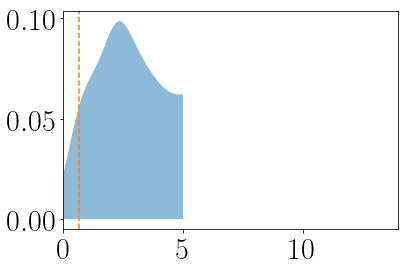

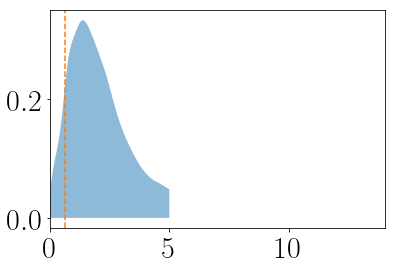

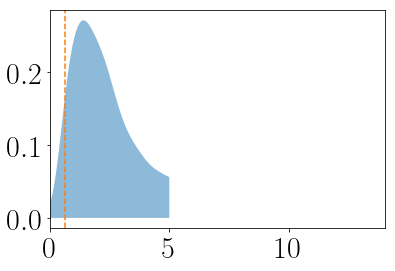

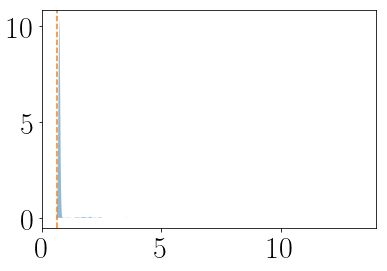

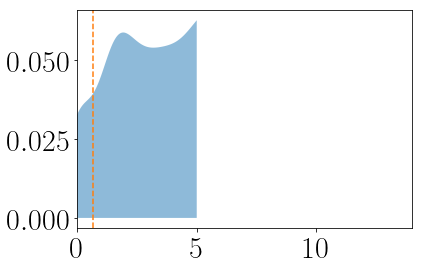

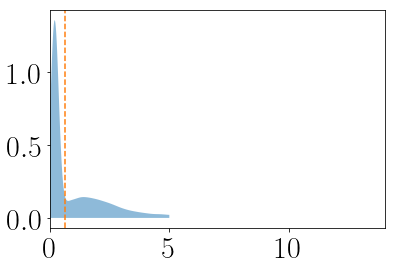

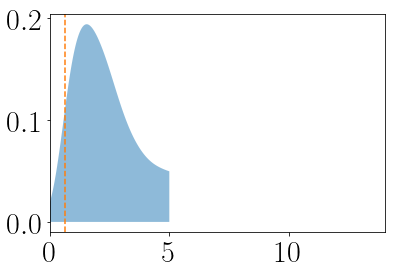

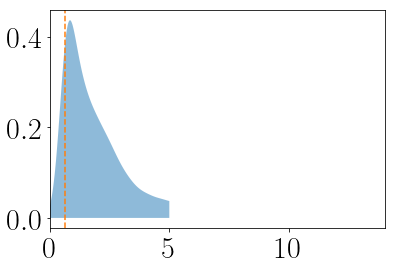

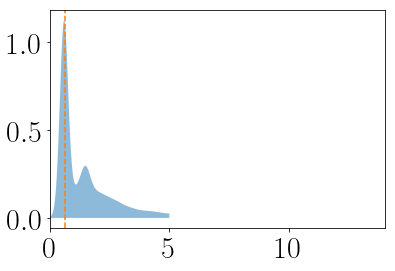

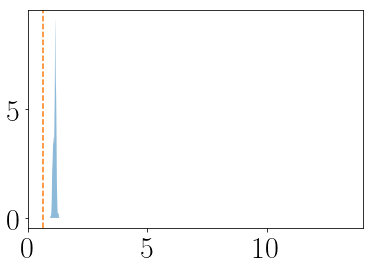

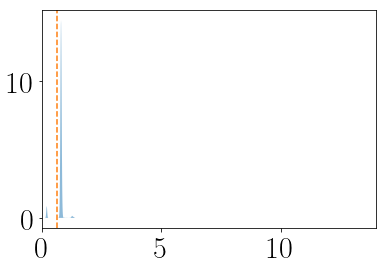

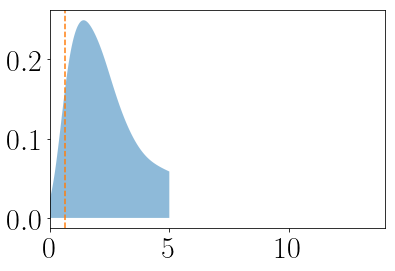

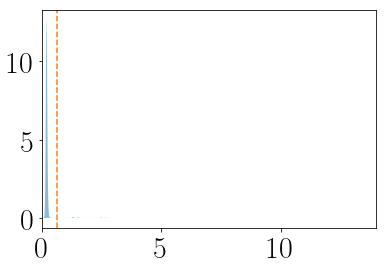

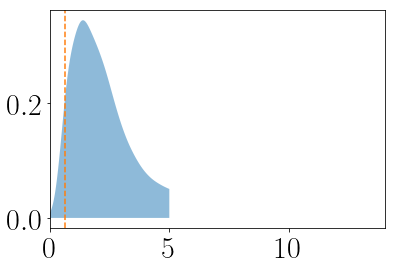

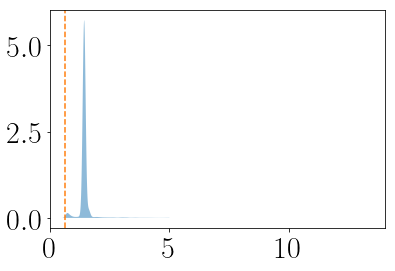

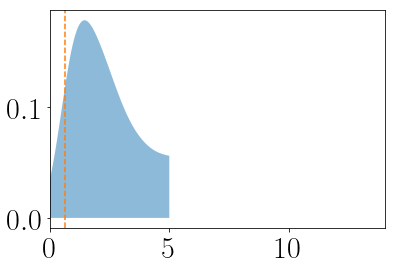

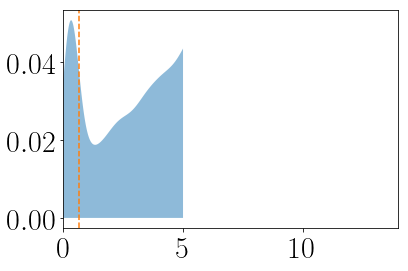

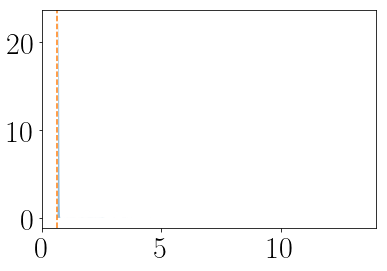

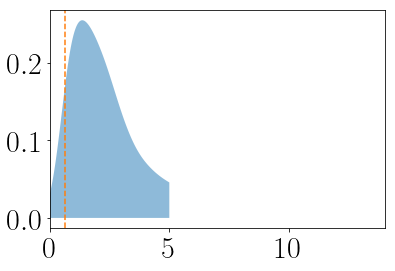

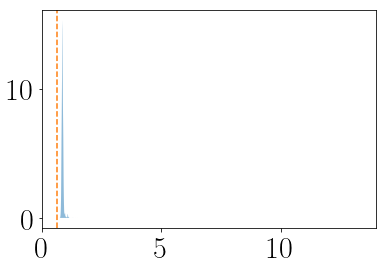

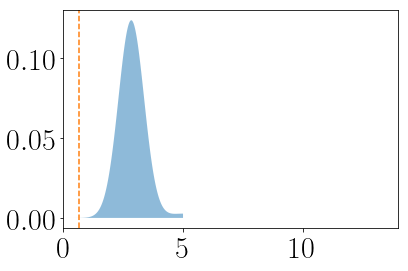

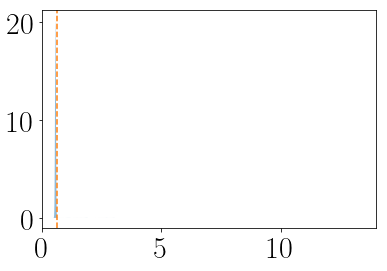

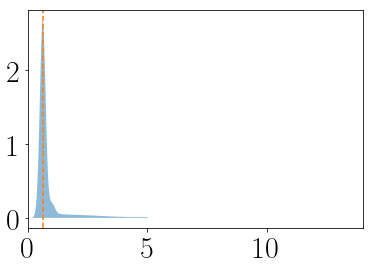

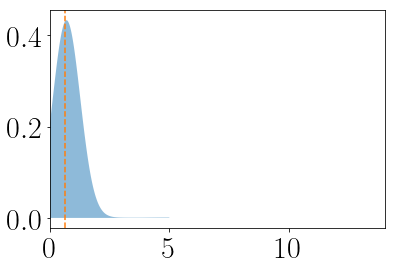

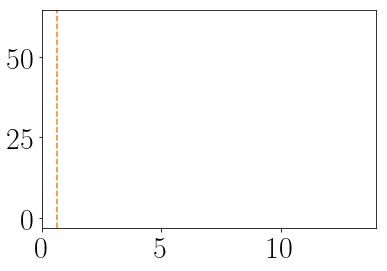

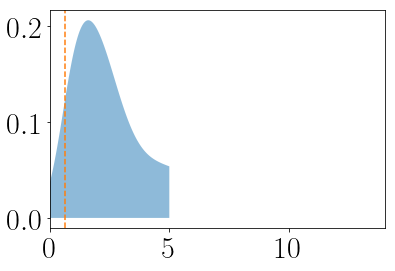

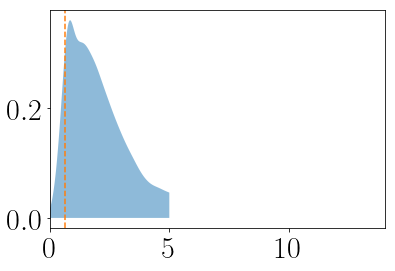

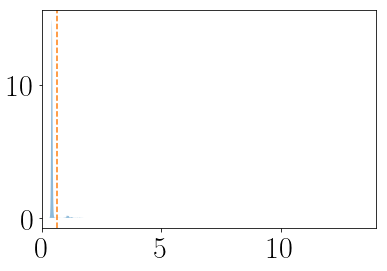

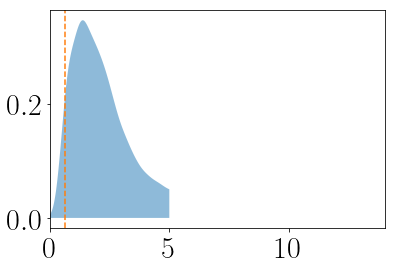

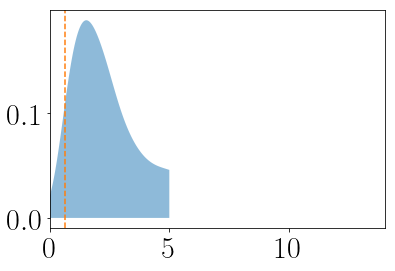

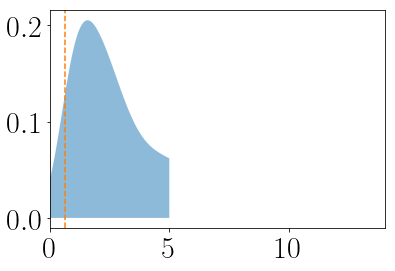

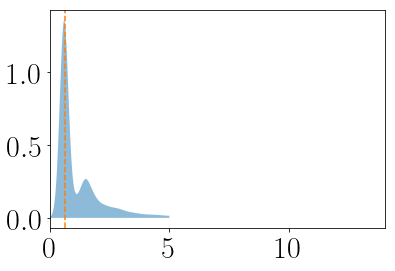

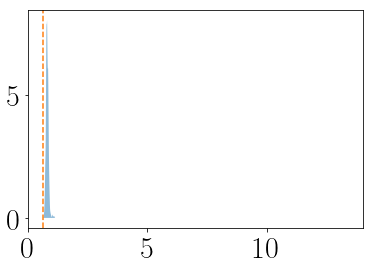

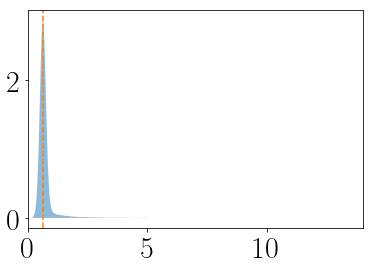

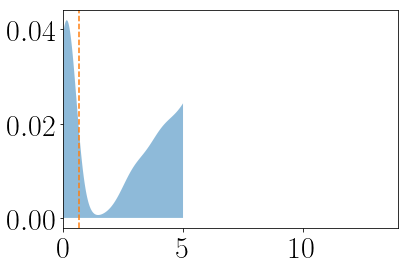

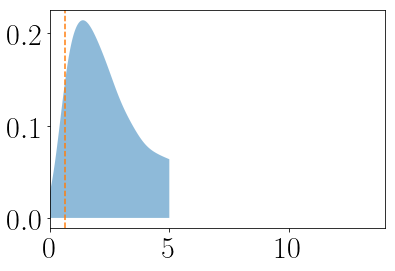

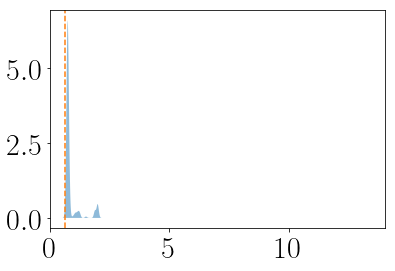

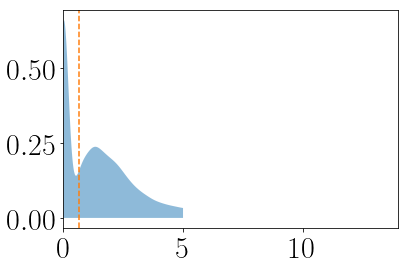

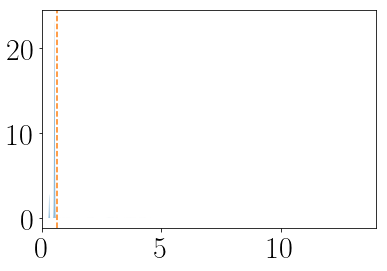

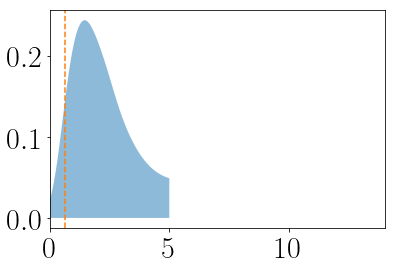

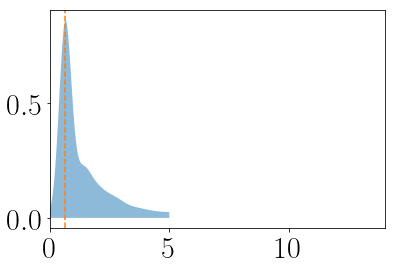

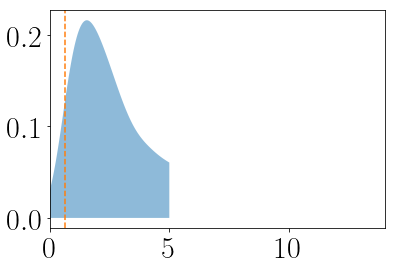

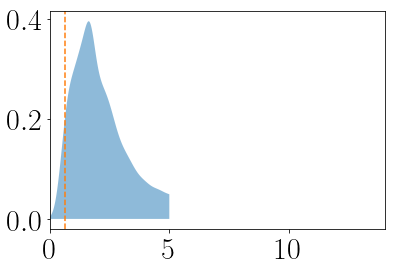

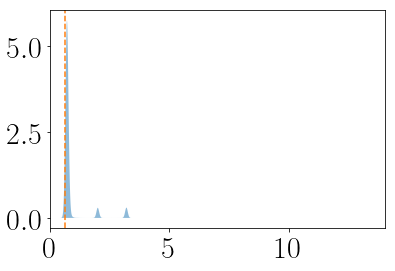

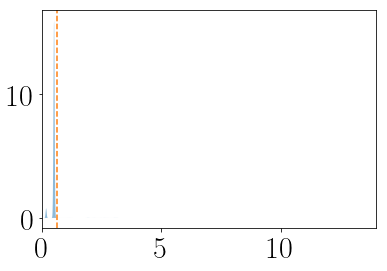

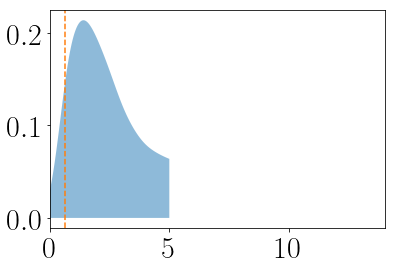

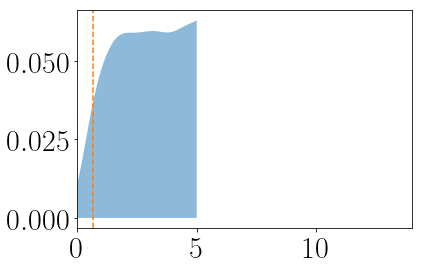

In [456]:
for i in pdf.i.values:
    kernel = sps.gaussian_kde(np.array(page_samps[i]))
    
    plt.subplot(1, 2, 1)
    plt.fill_between(xs, 0, kernel(xs), alpha=.5)
    plt.axvline(.65, color="C1", ls="--")
    plt.xlim(0, 14)
    
    plt.subplot(1, 2, 2)
    plt.show()

2.0523015832751508


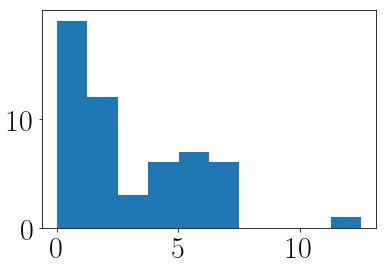

In [439]:
plt.hist(pdf.age_errp);
print(np.median(pdf.age_err))

0.8482478161804617


(0, 25)

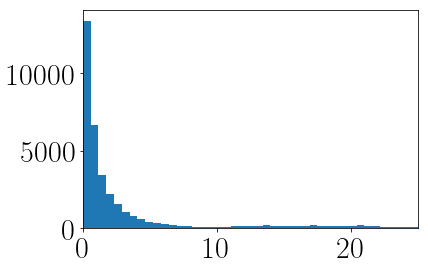

In [428]:
mc = pd.read_csv("data/Table_1_Periodic.txt")
plt.hist(mc.Prot_err/mc.Prot*100, 100);
print(np.median(mc.Prot_err/mc.Prot*100))
plt.xlim(0, 25)